# 03a11 At Only -- Random features

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle 
import time 
import random

from scipy import stats

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

from collections import Counter

import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
from atbotml.custom_fuctions import *

## Notebook parameters

In [63]:
nb_id = f'03a11c'
nb_long_id = f'{nb_id}_At_random'
num_classes = 10
random_state = 42

## Load data

In [3]:
# load complete training dataframe
df = pd.read_pickle("./01_AtBot_data.pkl")
print(f"Number of data samples: {len(df)}")
print(f"Number of features: {len(df.columns)-6}")

# extract feature names from RNASeq data
gene_names = list(df)[6:29107]

# Arabidopsis only feature gene set
n_At = 20340
At_list = gene_names[0:n_At]
print(f"Number of At genes: {n_At}")
df

Number of data samples: 1092
Number of features: 29101
Number of At genes: 20340


,Index,LibraryID,HostGenoType,Sample,Isolate,Lesion,AT1G01010,AT1G01040,AT1G01046,AT1G01050,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01,36.590004,39.556340,0.000000,0.000000,21.373592,...,0.0,0.000000,0.000000,0.000000,0.000000,12.438875,0.000000,0.000000,0.000000,5.321551
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01,36.590004,16.918722,0.000000,0.000000,119.029216,...,0.0,0.000000,0.000000,0.000000,0.000000,15.521645,0.000000,0.000000,0.000000,0.000000
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01,36.590004,14.735361,0.000000,0.000000,58.388002,...,0.0,0.000000,0.000000,0.000000,0.000000,76.250891,0.000000,0.000000,0.000000,0.000000
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01,36.590004,10.552052,0.000000,1.000161,19.548414,...,0.0,0.000000,0.000000,0.000000,0.000000,41.388120,73.847835,53.937879,0.000000,5.059001
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04,36.418731,15.229003,0.000000,0.000000,99.136624,...,0.0,15.577566,32.042486,0.000000,24.233666,47.555802,0.000000,54.228767,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,npr1_97,npr.1.G1F.972,npr1,97,1.05.16,20.747628,4.210585,0.226497,0.000000,88.664582,...,0.0,4.623277,12.227030,3.334425,16.953341,12.097817,0.000000,13.795366,0.000000,0.000000
1088,npr1_97,npr.1.G2E.971,npr1,97,1.05.16,20.747628,3.895372,0.000000,0.000000,18.900222,...,0.0,5.101576,16.951453,7.924833,14.651827,48.519908,11.222415,24.590291,1.537600,0.000000
1089,npr1_97,npr.1.G2E.972,npr1,97,1.05.16,20.747628,7.494782,0.000000,0.000000,14.318503,...,0.0,7.547289,19.236880,3.313311,15.314539,42.074248,18.768019,27.416028,0.642859,3.857151
1090,npr1_97,npr.1.G2F.971,npr1,97,1.05.16,20.747628,1.965208,0.000000,0.000000,23.361068,...,0.0,1.803102,16.690115,4.551550,37.868097,132.109896,103.127734,0.000000,0.000000,0.000000


### Features list

In [4]:
feature_title = "Degree"

random.seed(a=random_state, version=2)

features_lists = []

rand_iters = 100 # 10

topN = 1000

for i in range(rand_iters):
    random_samples = random.sample(At_list, k=topN)
    features_lists.append(random_samples)

### Training, validation, and test data

In [5]:
# load training, validation data
f = open("01_train_test_data.pkl", 'rb')
train_test_data = pickle.load(f)
f.close()

y_train = train_test_data['y_train']
y_test = train_test_data['y_test']
scaler = train_test_data['scaler']

df_X_train_samples = [0] * rand_iters
df_X_test_samples = [0] * rand_iters
df_At_X_test_scaled_samples = [0] * rand_iters
df_AtPsy_X_test_scaled_samples = [0] * rand_iters 

# X features (Training/Validation data)
for i in range(rand_iters):
    features_list = features_lists[i]

    df_X_train = train_test_data['df_X_train']
    df_X_train = df_X_train.loc[:,features_list]
    df_X_train_samples[i] = df_X_train

    df_X_test = train_test_data['df_X_test']
    df_X_test = df_X_test.loc[:,features_list]
    df_X_test_samples[i] = df_X_test
    
# At Only test data
f = open("01_At_test_data.pkl", 'rb')
df_At_X_test_scaled_file = pickle.load(f)
f.close()
    
for i in range(rand_iters):
    features_list = features_lists[i]
    
    df_At_X_test_scaled = df_At_X_test_scaled_file.loc[:,features_list]
    df_At_X_test_scaled_samples[i] = df_At_X_test_scaled
    
# At-Psy test data
filename = "../data/raw/test_set/AtNormTPMReadsStarMapAtPsy.csv"
df_test_psy_raw = pd.read_csv(filename)

f = open("01_AtPsy_test_data.pkl", 'rb')
df_AtPsy_X_test_scaled_file = pickle.load(f)
f.close()

df_AtPsy_X_test_scaled_file['Sample'] = df_test_psy_raw['Sample']
first_column = df_AtPsy_X_test_scaled_file.pop('Sample')
df_AtPsy_X_test_scaled_file.insert(0, 'Sample', first_column)

path = '03b_AtPsy_dnn_predictions'
df_atpsy_dnn = pd.read_pickle(path)

df_valid_AtPsy = pd.merge(df_AtPsy_X_test_scaled_file, 
                           df_atpsy_dnn[['Sample', 'Class']], 
                           on='Sample')

y_test_AtPsy = list(df_valid_AtPsy['Class'])
print(f'Number of valid At-Psy samples: {len(y_test_AtPsy)}')

# y_test_AtPsy

for i in range(rand_iters):
    features_list = features_lists[i]
    df_AtPsy_X_test_scaled = df_valid_AtPsy.loc[:,features_list]
    df_AtPsy_X_test_scaled_samples[i] = df_AtPsy_X_test_scaled

Number of valid At-Psy samples: 83


## DNN

In [6]:
# Run multiple iterations

dnn_y_preds = [0] * rand_iters
dnn_scores = [0] * rand_iters
dnn_cms = [0] * rand_iters
dnn_adj_scores = [0] * rand_iters

AtPsy_dnn_scores = [0] * rand_iters
AtPsy_dnn_cms = [0] * rand_iters
AtPsy_dnn_adj_scores = [0] * rand_iters

for i in range(rand_iters):
    X_train = df_X_train_samples[i].to_numpy()
    X_test = df_X_test_samples[i].to_numpy()
    At_X_test_scaled = df_At_X_test_scaled_samples[i].to_numpy()
    AtPsy_X_test_scaled = df_AtPsy_X_test_scaled_samples[i].to_numpy()

    model, history = train_dnn_1layer(X_train, y_train, X_test, y_test, num_classes, epochs=50)
    
    # Evaluate performance on Test set1
    predictions = model.predict(X_test)
    dnn_y_pred = np.argmax(predictions, 1)
    
    dnn_y_preds[i] = dnn_y_pred
    dnn_scores[i] = get_sk_metrics(y_test, dnn_y_pred)
    dnn_cms[i] = metrics.confusion_matrix(y_test, dnn_y_pred)
    dnn_adj_scores[i] = get_fuzzy_average_score(dnn_cms[i])
        
#     # Evaluate performance on Test set2
#     predictions = model.predict(At_X_test_scaled)
#     dnn_y_pred = np.argmax(predictions, 1)

    # Evaluate performance on Test set3 (AtPsy)
    X_test_scaled = AtPsy_X_test_scaled

    predictions = model.predict(X_test_scaled)
    dnn_AtPsy_y_pred = np.argmax(predictions, 1)
    AtPsy_dnn_scores[i] = get_sk_metrics(y_test_AtPsy, dnn_AtPsy_y_pred)
    AtPsy_dnn_cms[i] = metrics.confusion_matrix(y_test_AtPsy, dnn_AtPsy_y_pred)
    AtPsy_dnn_adj_scores[i] = get_fuzzy_average_score(AtPsy_dnn_cms[i])

Epoch 1/50


2021-09-22 08:16:10.260213: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 08:16:10.260376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 08:16:10.298901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


65/65 [==============================] - 1s 10ms/step - loss: 2.0951 - sparse_categorical_accuracy: 0.3999 - val_loss: 2.5226 - val_sparse_categorical_accuracy: 0.2378
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.8056 - val_loss: 2.6866 - val_sparse_categorical_accuracy: 0.2409
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3995 - sparse_categorical_accuracy: 0.8694 - val_loss: 2.9475 - val_sparse_categorical_accuracy: 0.2470
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9216 - val_loss: 3.1593 - val_sparse_categorical_accuracy: 0.2530
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1574 - sparse_categorical_accuracy: 0.9625 - val_loss: 3.1368 - val_sparse_categorical_accuracy: 0.2652
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.9653 - v

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0234 - sparse_categorical_accuracy: 0.4284 - val_loss: 2.4666 - val_sparse_categorical_accuracy: 0.2409
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5969 - sparse_categorical_accuracy: 0.8087 - val_loss: 2.5912 - val_sparse_categorical_accuracy: 0.3262
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.8728 - val_loss: 2.7765 - val_sparse_categorical_accuracy: 0.3018
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2275 - sparse_categorical_accuracy: 0.9322 - val_loss: 2.8596 - val_sparse_categorical_accuracy: 0.2713
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.9502 - val_loss: 3.1655 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1596 - sparse_categorical_accuracy: 0.9529 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.0129 - sparse_categorical_accuracy: 0.4257 - val_loss: 2.4787 - val_sparse_categorical_accuracy: 0.2866
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.8004 - val_loss: 2.6839 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3378 - sparse_categorical_accuracy: 0.8950 - val_loss: 2.8522 - val_sparse_categorical_accuracy: 0.2805
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2263 - sparse_categorical_accuracy: 0.9327 - val_loss: 2.9817 - val_sparse_categorical_accuracy: 0.3140
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.9474 - val_loss: 3.2141 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9601 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 1.9973 - sparse_categorical_accuracy: 0.4302 - val_loss: 2.4158 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5709 - sparse_categorical_accuracy: 0.8084 - val_loss: 2.7075 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3488 - sparse_categorical_accuracy: 0.8838 - val_loss: 2.7114 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9239 - val_loss: 3.1739 - val_sparse_categorical_accuracy: 0.2988
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9524 - val_loss: 3.2766 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1364 - sparse_categorical_accuracy: 0.9612 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1791 - sparse_categorical_accuracy: 0.4021 - val_loss: 2.4909 - val_sparse_categorical_accuracy: 0.2348
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5814 - sparse_categorical_accuracy: 0.8048 - val_loss: 2.6672 - val_sparse_categorical_accuracy: 0.2988
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3505 - sparse_categorical_accuracy: 0.8978 - val_loss: 2.6716 - val_sparse_categorical_accuracy: 0.2622
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2144 - sparse_categorical_accuracy: 0.9466 - val_loss: 2.9902 - val_sparse_categorical_accuracy: 0.2439
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2099 - sparse_categorical_accuracy: 0.9396 - val_loss: 3.0514 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9608 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0628 - sparse_categorical_accuracy: 0.4334 - val_loss: 2.4039 - val_sparse_categorical_accuracy: 0.2866
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6200 - sparse_categorical_accuracy: 0.8007 - val_loss: 2.4808 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3577 - sparse_categorical_accuracy: 0.8765 - val_loss: 2.5562 - val_sparse_categorical_accuracy: 0.3201
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2431 - sparse_categorical_accuracy: 0.9328 - val_loss: 2.7763 - val_sparse_categorical_accuracy: 0.2866
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1712 - sparse_categorical_accuracy: 0.9508 - val_loss: 3.0207 - val_sparse_categorical_accuracy: 0.3232
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.9632 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0810 - sparse_categorical_accuracy: 0.3945 - val_loss: 2.5402 - val_sparse_categorical_accuracy: 0.2287
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5808 - sparse_categorical_accuracy: 0.8071 - val_loss: 2.5272 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8805 - val_loss: 2.8091 - val_sparse_categorical_accuracy: 0.3079
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2222 - sparse_categorical_accuracy: 0.9325 - val_loss: 3.0142 - val_sparse_categorical_accuracy: 0.3049
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.9503 - val_loss: 3.0544 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1411 - sparse_categorical_accuracy: 0.9590 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 7ms/step - loss: 2.0483 - sparse_categorical_accuracy: 0.4029 - val_loss: 2.4158 - val_sparse_categorical_accuracy: 0.2927
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7941 - val_loss: 2.5464 - val_sparse_categorical_accuracy: 0.2470
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8848 - val_loss: 2.6445 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.9158 - val_loss: 2.7862 - val_sparse_categorical_accuracy: 0.3049
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9497 - val_loss: 2.9875 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1576 - sparse_categorical_accuracy: 0.9480 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0119 - sparse_categorical_accuracy: 0.4177 - val_loss: 2.4744 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6222 - sparse_categorical_accuracy: 0.7886 - val_loss: 2.5626 - val_sparse_categorical_accuracy: 0.2744
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3539 - sparse_categorical_accuracy: 0.8807 - val_loss: 2.6683 - val_sparse_categorical_accuracy: 0.2805
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2199 - sparse_categorical_accuracy: 0.9333 - val_loss: 2.8252 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1920 - sparse_categorical_accuracy: 0.9523 - val_loss: 3.1566 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1376 - sparse_categorical_accuracy: 0.9547 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0881 - sparse_categorical_accuracy: 0.4177 - val_loss: 2.6467 - val_sparse_categorical_accuracy: 0.2530
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.8062 - val_loss: 3.1754 - val_sparse_categorical_accuracy: 0.2591
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3963 - sparse_categorical_accuracy: 0.8675 - val_loss: 3.0561 - val_sparse_categorical_accuracy: 0.3171
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2539 - sparse_categorical_accuracy: 0.9329 - val_loss: 3.3518 - val_sparse_categorical_accuracy: 0.2713
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1438 - sparse_categorical_accuracy: 0.9545 - val_loss: 3.5625 - val_sparse_categorical_accuracy: 0.2957
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1282 - sparse_categorical_accuracy: 0.9678 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1327 - sparse_categorical_accuracy: 0.4149 - val_loss: 2.7903 - val_sparse_categorical_accuracy: 0.2744
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5638 - sparse_categorical_accuracy: 0.8144 - val_loss: 2.7649 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3816 - sparse_categorical_accuracy: 0.8751 - val_loss: 3.0344 - val_sparse_categorical_accuracy: 0.2744
Epoch 4/50
65/65 [==============================] - 0s 2ms/step - loss: 0.2921 - sparse_categorical_accuracy: 0.9178 - val_loss: 3.3262 - val_sparse_categorical_accuracy: 0.2835
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2011 - sparse_categorical_accuracy: 0.9387 - val_loss: 3.2592 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1400 - sparse_categorical_accuracy: 0.9608 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0810 - sparse_categorical_accuracy: 0.4190 - val_loss: 2.5193 - val_sparse_categorical_accuracy: 0.2774
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.7949 - val_loss: 2.6046 - val_sparse_categorical_accuracy: 0.3079
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4032 - sparse_categorical_accuracy: 0.8768 - val_loss: 2.8341 - val_sparse_categorical_accuracy: 0.2591
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2789 - sparse_categorical_accuracy: 0.9022 - val_loss: 2.7671 - val_sparse_categorical_accuracy: 0.2957
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9418 - val_loss: 2.9882 - val_sparse_categorical_accuracy: 0.2652
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9695 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0389 - sparse_categorical_accuracy: 0.4155 - val_loss: 2.5005 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.7976 - val_loss: 2.6036 - val_sparse_categorical_accuracy: 0.2439
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3841 - sparse_categorical_accuracy: 0.8747 - val_loss: 2.8393 - val_sparse_categorical_accuracy: 0.3018
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2645 - sparse_categorical_accuracy: 0.9177 - val_loss: 2.8614 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.9537 - val_loss: 3.2497 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9714 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0194 - sparse_categorical_accuracy: 0.4292 - val_loss: 2.4378 - val_sparse_categorical_accuracy: 0.2896
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5935 - sparse_categorical_accuracy: 0.8040 - val_loss: 2.4600 - val_sparse_categorical_accuracy: 0.2866
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8873 - val_loss: 2.7580 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2677 - sparse_categorical_accuracy: 0.9248 - val_loss: 3.0086 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1539 - sparse_categorical_accuracy: 0.9538 - val_loss: 3.0484 - val_sparse_categorical_accuracy: 0.2774
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1015 - sparse_categorical_accuracy: 0.9761 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 0s 4ms/step - loss: 2.1972 - sparse_categorical_accuracy: 0.3875 - val_loss: 2.5573 - val_sparse_categorical_accuracy: 0.2195
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6157 - sparse_categorical_accuracy: 0.8002 - val_loss: 2.6480 - val_sparse_categorical_accuracy: 0.2713
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3274 - sparse_categorical_accuracy: 0.8950 - val_loss: 2.5682 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2171 - sparse_categorical_accuracy: 0.9296 - val_loss: 2.8528 - val_sparse_categorical_accuracy: 0.2652
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9515 - val_loss: 3.0847 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 2ms/step - loss: 0.1056 - sparse_categorical_accuracy: 0.9667 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0017 - sparse_categorical_accuracy: 0.4101 - val_loss: 2.6001 - val_sparse_categorical_accuracy: 0.2348
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5896 - sparse_categorical_accuracy: 0.8128 - val_loss: 2.7335 - val_sparse_categorical_accuracy: 0.2866
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3674 - sparse_categorical_accuracy: 0.8852 - val_loss: 3.0264 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2684 - sparse_categorical_accuracy: 0.9236 - val_loss: 3.0127 - val_sparse_categorical_accuracy: 0.2530
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9415 - val_loss: 3.2976 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9684 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1208 - sparse_categorical_accuracy: 0.3932 - val_loss: 2.3885 - val_sparse_categorical_accuracy: 0.2652
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5961 - sparse_categorical_accuracy: 0.8027 - val_loss: 2.5681 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3415 - sparse_categorical_accuracy: 0.8888 - val_loss: 2.7381 - val_sparse_categorical_accuracy: 0.2988
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2195 - sparse_categorical_accuracy: 0.9271 - val_loss: 2.9198 - val_sparse_categorical_accuracy: 0.2591
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1583 - sparse_categorical_accuracy: 0.9536 - val_loss: 3.0215 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.9618 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1071 - sparse_categorical_accuracy: 0.4093 - val_loss: 2.5384 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5868 - sparse_categorical_accuracy: 0.8208 - val_loss: 2.6377 - val_sparse_categorical_accuracy: 0.2988
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3829 - sparse_categorical_accuracy: 0.8801 - val_loss: 2.6766 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9334 - val_loss: 2.8566 - val_sparse_categorical_accuracy: 0.3171
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1923 - sparse_categorical_accuracy: 0.9409 - val_loss: 3.0959 - val_sparse_categorical_accuracy: 0.3079
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9583 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0804 - sparse_categorical_accuracy: 0.4152 - val_loss: 2.5148 - val_sparse_categorical_accuracy: 0.2988
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.7941 - val_loss: 2.4972 - val_sparse_categorical_accuracy: 0.2927
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3475 - sparse_categorical_accuracy: 0.8887 - val_loss: 2.6062 - val_sparse_categorical_accuracy: 0.3140
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9329 - val_loss: 2.7280 - val_sparse_categorical_accuracy: 0.2957
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.9573 - val_loss: 2.8521 - val_sparse_categorical_accuracy: 0.3232
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9655 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0783 - sparse_categorical_accuracy: 0.4058 - val_loss: 2.4417 - val_sparse_categorical_accuracy: 0.2866
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6355 - sparse_categorical_accuracy: 0.7994 - val_loss: 2.5972 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.8899 - val_loss: 2.9643 - val_sparse_categorical_accuracy: 0.2744
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2610 - sparse_categorical_accuracy: 0.9276 - val_loss: 3.1667 - val_sparse_categorical_accuracy: 0.2378
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9517 - val_loss: 3.2413 - val_sparse_categorical_accuracy: 0.2287
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1383 - sparse_categorical_accuracy: 0.9595 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 1.9859 - sparse_categorical_accuracy: 0.4232 - val_loss: 2.5120 - val_sparse_categorical_accuracy: 0.2713
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.7998 - val_loss: 2.5512 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3726 - sparse_categorical_accuracy: 0.8791 - val_loss: 2.6324 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9253 - val_loss: 2.9079 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9399 - val_loss: 2.9108 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.9677 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0123 - sparse_categorical_accuracy: 0.4134 - val_loss: 2.7210 - val_sparse_categorical_accuracy: 0.2470
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.8017 - val_loss: 2.8424 - val_sparse_categorical_accuracy: 0.2774
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3883 - sparse_categorical_accuracy: 0.8783 - val_loss: 2.8576 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9314 - val_loss: 3.0814 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1954 - sparse_categorical_accuracy: 0.9519 - val_loss: 3.2135 - val_sparse_categorical_accuracy: 0.2591
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1360 - sparse_categorical_accuracy: 0.9580 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0823 - sparse_categorical_accuracy: 0.3990 - val_loss: 2.5201 - val_sparse_categorical_accuracy: 0.2866
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6305 - sparse_categorical_accuracy: 0.7987 - val_loss: 2.5517 - val_sparse_categorical_accuracy: 0.2866
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3455 - sparse_categorical_accuracy: 0.8845 - val_loss: 2.7236 - val_sparse_categorical_accuracy: 0.2866
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2085 - sparse_categorical_accuracy: 0.9379 - val_loss: 2.8399 - val_sparse_categorical_accuracy: 0.2652
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1366 - sparse_categorical_accuracy: 0.9624 - val_loss: 3.0009 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9750 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1558 - sparse_categorical_accuracy: 0.3863 - val_loss: 2.6078 - val_sparse_categorical_accuracy: 0.2317
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6687 - sparse_categorical_accuracy: 0.7922 - val_loss: 2.7816 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.8985 - val_loss: 3.0126 - val_sparse_categorical_accuracy: 0.2866
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2217 - sparse_categorical_accuracy: 0.9381 - val_loss: 3.1918 - val_sparse_categorical_accuracy: 0.3171
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2044 - sparse_categorical_accuracy: 0.9391 - val_loss: 3.2028 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.9664 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1569 - sparse_categorical_accuracy: 0.3852 - val_loss: 2.5954 - val_sparse_categorical_accuracy: 0.2256
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5847 - sparse_categorical_accuracy: 0.8078 - val_loss: 2.6925 - val_sparse_categorical_accuracy: 0.2713
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3336 - sparse_categorical_accuracy: 0.8889 - val_loss: 2.8371 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2126 - sparse_categorical_accuracy: 0.9336 - val_loss: 2.9899 - val_sparse_categorical_accuracy: 0.2927
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9602 - val_loss: 3.0678 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.9555 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 0s 4ms/step - loss: 2.0254 - sparse_categorical_accuracy: 0.4146 - val_loss: 2.7175 - val_sparse_categorical_accuracy: 0.2744
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.7823 - val_loss: 2.6918 - val_sparse_categorical_accuracy: 0.2530
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3589 - sparse_categorical_accuracy: 0.8799 - val_loss: 2.8180 - val_sparse_categorical_accuracy: 0.2957
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.9063 - val_loss: 2.9806 - val_sparse_categorical_accuracy: 0.2622
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2161 - sparse_categorical_accuracy: 0.9399 - val_loss: 3.1719 - val_sparse_categorical_accuracy: 0.2774
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1367 - sparse_categorical_accuracy: 0.9588 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.0555 - sparse_categorical_accuracy: 0.4398 - val_loss: 2.4665 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6003 - sparse_categorical_accuracy: 0.8172 - val_loss: 2.5996 - val_sparse_categorical_accuracy: 0.2774
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3523 - sparse_categorical_accuracy: 0.8861 - val_loss: 2.7948 - val_sparse_categorical_accuracy: 0.2835
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2509 - sparse_categorical_accuracy: 0.9142 - val_loss: 2.9666 - val_sparse_categorical_accuracy: 0.3140
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2101 - sparse_categorical_accuracy: 0.9291 - val_loss: 3.1278 - val_sparse_categorical_accuracy: 0.2774
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9703 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 0s 4ms/step - loss: 2.0796 - sparse_categorical_accuracy: 0.4202 - val_loss: 2.6321 - val_sparse_categorical_accuracy: 0.2043
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6093 - sparse_categorical_accuracy: 0.8019 - val_loss: 2.5570 - val_sparse_categorical_accuracy: 0.2256
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3570 - sparse_categorical_accuracy: 0.8796 - val_loss: 2.7194 - val_sparse_categorical_accuracy: 0.2348
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2164 - sparse_categorical_accuracy: 0.9359 - val_loss: 2.9159 - val_sparse_categorical_accuracy: 0.2591
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9566 - val_loss: 2.9947 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1328 - sparse_categorical_accuracy: 0.9574 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0168 - sparse_categorical_accuracy: 0.4141 - val_loss: 2.6717 - val_sparse_categorical_accuracy: 0.2378
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5672 - sparse_categorical_accuracy: 0.8132 - val_loss: 2.7997 - val_sparse_categorical_accuracy: 0.3018
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3226 - sparse_categorical_accuracy: 0.8918 - val_loss: 2.9335 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9304 - val_loss: 3.2003 - val_sparse_categorical_accuracy: 0.2866
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.9525 - val_loss: 3.4503 - val_sparse_categorical_accuracy: 0.3079
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9653 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 0s 4ms/step - loss: 2.0717 - sparse_categorical_accuracy: 0.4191 - val_loss: 2.3794 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6029 - sparse_categorical_accuracy: 0.8100 - val_loss: 2.6351 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8893 - val_loss: 2.9332 - val_sparse_categorical_accuracy: 0.2957
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1905 - sparse_categorical_accuracy: 0.9372 - val_loss: 3.0243 - val_sparse_categorical_accuracy: 0.3232
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1919 - sparse_categorical_accuracy: 0.9479 - val_loss: 3.2844 - val_sparse_categorical_accuracy: 0.3079
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.9484 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 1.9970 - sparse_categorical_accuracy: 0.4234 - val_loss: 2.3550 - val_sparse_categorical_accuracy: 0.3140
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6057 - sparse_categorical_accuracy: 0.7947 - val_loss: 2.5297 - val_sparse_categorical_accuracy: 0.3232
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3855 - sparse_categorical_accuracy: 0.8757 - val_loss: 2.6940 - val_sparse_categorical_accuracy: 0.3079
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9403 - val_loss: 2.8578 - val_sparse_categorical_accuracy: 0.2835
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9477 - val_loss: 3.0861 - val_sparse_categorical_accuracy: 0.3384
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9676 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0474 - sparse_categorical_accuracy: 0.4256 - val_loss: 2.6036 - val_sparse_categorical_accuracy: 0.2348
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6221 - sparse_categorical_accuracy: 0.8079 - val_loss: 2.5816 - val_sparse_categorical_accuracy: 0.2348
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.8907 - val_loss: 2.8489 - val_sparse_categorical_accuracy: 0.2409
Epoch 4/50
65/65 [==============================] - 0s 7ms/step - loss: 0.2541 - sparse_categorical_accuracy: 0.9097 - val_loss: 2.9471 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9451 - val_loss: 3.0557 - val_sparse_categorical_accuracy: 0.2530
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9502 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.0250 - sparse_categorical_accuracy: 0.4180 - val_loss: 2.4235 - val_sparse_categorical_accuracy: 0.2622
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.8021 - val_loss: 2.6041 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.8794 - val_loss: 2.9219 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2476 - sparse_categorical_accuracy: 0.9242 - val_loss: 2.8822 - val_sparse_categorical_accuracy: 0.2805
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1367 - sparse_categorical_accuracy: 0.9629 - val_loss: 3.1888 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1177 - sparse_categorical_accuracy: 0.9615 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0296 - sparse_categorical_accuracy: 0.4167 - val_loss: 2.5436 - val_sparse_categorical_accuracy: 0.2744
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6185 - sparse_categorical_accuracy: 0.7980 - val_loss: 2.6260 - val_sparse_categorical_accuracy: 0.2317
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.8672 - val_loss: 2.8329 - val_sparse_categorical_accuracy: 0.2744
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3059 - sparse_categorical_accuracy: 0.9071 - val_loss: 2.9921 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9617 - val_loss: 3.2570 - val_sparse_categorical_accuracy: 0.2713
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9617 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0744 - sparse_categorical_accuracy: 0.4164 - val_loss: 2.7046 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.8007 - val_loss: 2.8208 - val_sparse_categorical_accuracy: 0.2378
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3464 - sparse_categorical_accuracy: 0.8849 - val_loss: 2.9967 - val_sparse_categorical_accuracy: 0.2835
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1983 - sparse_categorical_accuracy: 0.9420 - val_loss: 3.1282 - val_sparse_categorical_accuracy: 0.2805
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.9523 - val_loss: 3.2939 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.9615 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9876 - sparse_categorical_accuracy: 0.4304 - val_loss: 2.5704 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5759 - sparse_categorical_accuracy: 0.8042 - val_loss: 2.5652 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3550 - sparse_categorical_accuracy: 0.9012 - val_loss: 2.8270 - val_sparse_categorical_accuracy: 0.2530
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2324 - sparse_categorical_accuracy: 0.9227 - val_loss: 2.8346 - val_sparse_categorical_accuracy: 0.2927
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1391 - sparse_categorical_accuracy: 0.9603 - val_loss: 3.2036 - val_sparse_categorical_accuracy: 0.2805
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1414 - sparse_categorical_accuracy: 0.9587 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0544 - sparse_categorical_accuracy: 0.4207 - val_loss: 2.6617 - val_sparse_categorical_accuracy: 0.2530
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.7984 - val_loss: 2.5858 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3696 - sparse_categorical_accuracy: 0.8836 - val_loss: 2.7274 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2033 - sparse_categorical_accuracy: 0.9400 - val_loss: 2.9146 - val_sparse_categorical_accuracy: 0.2652
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.9579 - val_loss: 3.1741 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9634 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.0579 - sparse_categorical_accuracy: 0.4077 - val_loss: 2.3798 - val_sparse_categorical_accuracy: 0.2622
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.7937 - val_loss: 2.4078 - val_sparse_categorical_accuracy: 0.3232
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.9037 - val_loss: 2.6322 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2660 - sparse_categorical_accuracy: 0.9112 - val_loss: 2.9233 - val_sparse_categorical_accuracy: 0.3079
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1569 - sparse_categorical_accuracy: 0.9593 - val_loss: 3.1154 - val_sparse_categorical_accuracy: 0.2744
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9592 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0593 - sparse_categorical_accuracy: 0.4021 - val_loss: 2.5574 - val_sparse_categorical_accuracy: 0.2683
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.8017 - val_loss: 2.7012 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3671 - sparse_categorical_accuracy: 0.8834 - val_loss: 2.7933 - val_sparse_categorical_accuracy: 0.2927
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9154 - val_loss: 2.9985 - val_sparse_categorical_accuracy: 0.3018
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1878 - sparse_categorical_accuracy: 0.9399 - val_loss: 3.4300 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1338 - sparse_categorical_accuracy: 0.9624 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0323 - sparse_categorical_accuracy: 0.4320 - val_loss: 2.7191 - val_sparse_categorical_accuracy: 0.2287
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5447 - sparse_categorical_accuracy: 0.8236 - val_loss: 2.7615 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3244 - sparse_categorical_accuracy: 0.8928 - val_loss: 2.8948 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9172 - val_loss: 3.1198 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.9477 - val_loss: 3.3206 - val_sparse_categorical_accuracy: 0.2652
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.9575 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 38.55%
Precision:	 10.77%
Recall:		 13.21%
F1 score:	 10.83%
Epoch 1/50
65/65 [==============================] - 1s 5ms/step - loss: 2.0094 - sparse_categorical_accuracy: 0.4364 - val_loss: 2.6782 - val_sparse_categorical_accuracy: 0.2104
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6611 - sparse_categorical_accuracy: 0.7856 - val_loss: 2.6203 - val_sparse_categorical_accuracy: 0.2165
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3683 - sparse_categorical_accuracy: 0.8891 - val_loss: 2.8713 - val_sparse_categorical_accuracy: 0.2470
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2303 - sparse_categorical_accuracy: 0.9321 - val_loss: 2.9998 - val_sparse_categorical_accuracy: 0.2805
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1395 - sparse_categorical_accuracy: 0.9664 - val_loss: 3.0467 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [====================

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0368 - sparse_categorical_accuracy: 0.4316 - val_loss: 2.5138 - val_sparse_categorical_accuracy: 0.2652
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6132 - sparse_categorical_accuracy: 0.8196 - val_loss: 2.7022 - val_sparse_categorical_accuracy: 0.2927
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3905 - sparse_categorical_accuracy: 0.8732 - val_loss: 2.7660 - val_sparse_categorical_accuracy: 0.2622
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2367 - sparse_categorical_accuracy: 0.9278 - val_loss: 3.1212 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9472 - val_loss: 3.2267 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9711 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1248 - sparse_categorical_accuracy: 0.3894 - val_loss: 2.5379 - val_sparse_categorical_accuracy: 0.2165
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5928 - sparse_categorical_accuracy: 0.8054 - val_loss: 2.5105 - val_sparse_categorical_accuracy: 0.2470
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3532 - sparse_categorical_accuracy: 0.8868 - val_loss: 2.7780 - val_sparse_categorical_accuracy: 0.2622
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9331 - val_loss: 2.8804 - val_sparse_categorical_accuracy: 0.2652
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2034 - sparse_categorical_accuracy: 0.9363 - val_loss: 3.0545 - val_sparse_categorical_accuracy: 0.2774
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1395 - sparse_categorical_accuracy: 0.9606 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1237 - sparse_categorical_accuracy: 0.4020 - val_loss: 2.3996 - val_sparse_categorical_accuracy: 0.2165
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5960 - sparse_categorical_accuracy: 0.8019 - val_loss: 2.4927 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3554 - sparse_categorical_accuracy: 0.8808 - val_loss: 2.7685 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.9197 - val_loss: 2.8493 - val_sparse_categorical_accuracy: 0.2835
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1588 - sparse_categorical_accuracy: 0.9501 - val_loss: 3.0825 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1413 - sparse_categorical_accuracy: 0.9584 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0174 - sparse_categorical_accuracy: 0.4159 - val_loss: 2.5021 - val_sparse_categorical_accuracy: 0.2713
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5942 - sparse_categorical_accuracy: 0.7987 - val_loss: 2.5028 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.8917 - val_loss: 2.7189 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9302 - val_loss: 3.0108 - val_sparse_categorical_accuracy: 0.2622
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.9524 - val_loss: 3.3164 - val_sparse_categorical_accuracy: 0.2744
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9560 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0667 - sparse_categorical_accuracy: 0.4133 - val_loss: 2.3878 - val_sparse_categorical_accuracy: 0.2988
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.7959 - val_loss: 2.5141 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3322 - sparse_categorical_accuracy: 0.8995 - val_loss: 2.6593 - val_sparse_categorical_accuracy: 0.3018
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.9199 - val_loss: 2.8522 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9549 - val_loss: 3.0001 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.9550 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 4ms/step - loss: 1.9478 - sparse_categorical_accuracy: 0.4226 - val_loss: 2.4062 - val_sparse_categorical_accuracy: 0.2835
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6827 - sparse_categorical_accuracy: 0.7807 - val_loss: 2.6116 - val_sparse_categorical_accuracy: 0.2530
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3267 - sparse_categorical_accuracy: 0.8996 - val_loss: 2.7703 - val_sparse_categorical_accuracy: 0.3140
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2392 - sparse_categorical_accuracy: 0.9094 - val_loss: 2.9509 - val_sparse_categorical_accuracy: 0.2591
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1890 - sparse_categorical_accuracy: 0.9474 - val_loss: 2.9030 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9499 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.0708 - sparse_categorical_accuracy: 0.4099 - val_loss: 2.4157 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.8009 - val_loss: 2.3937 - val_sparse_categorical_accuracy: 0.2409
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3715 - sparse_categorical_accuracy: 0.8768 - val_loss: 2.6310 - val_sparse_categorical_accuracy: 0.2866
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2618 - sparse_categorical_accuracy: 0.9115 - val_loss: 2.7240 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.9466 - val_loss: 2.8610 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1440 - sparse_categorical_accuracy: 0.9559 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.1446 - sparse_categorical_accuracy: 0.4123 - val_loss: 2.4768 - val_sparse_categorical_accuracy: 0.2774
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6696 - sparse_categorical_accuracy: 0.7974 - val_loss: 2.6122 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.8850 - val_loss: 2.6611 - val_sparse_categorical_accuracy: 0.3110
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.9133 - val_loss: 3.0774 - val_sparse_categorical_accuracy: 0.3201
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1905 - sparse_categorical_accuracy: 0.9443 - val_loss: 3.2131 - val_sparse_categorical_accuracy: 0.2805
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.9623 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0397 - sparse_categorical_accuracy: 0.4013 - val_loss: 2.5335 - val_sparse_categorical_accuracy: 0.3110
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6806 - sparse_categorical_accuracy: 0.7939 - val_loss: 2.5868 - val_sparse_categorical_accuracy: 0.3110
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.8832 - val_loss: 2.6640 - val_sparse_categorical_accuracy: 0.3354
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2356 - sparse_categorical_accuracy: 0.9225 - val_loss: 2.7454 - val_sparse_categorical_accuracy: 0.3232
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.9528 - val_loss: 2.9509 - val_sparse_categorical_accuracy: 0.3262
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9732 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9260 - sparse_categorical_accuracy: 0.4289 - val_loss: 2.4382 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5982 - sparse_categorical_accuracy: 0.8041 - val_loss: 2.7027 - val_sparse_categorical_accuracy: 0.2378
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3451 - sparse_categorical_accuracy: 0.8930 - val_loss: 2.8829 - val_sparse_categorical_accuracy: 0.2744
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2144 - sparse_categorical_accuracy: 0.9272 - val_loss: 3.0344 - val_sparse_categorical_accuracy: 0.3323
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1578 - sparse_categorical_accuracy: 0.9546 - val_loss: 3.2282 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9542 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 6ms/step - loss: 2.0680 - sparse_categorical_accuracy: 0.4220 - val_loss: 2.6026 - val_sparse_categorical_accuracy: 0.2591
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5295 - sparse_categorical_accuracy: 0.8272 - val_loss: 2.6973 - val_sparse_categorical_accuracy: 0.2652
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.8785 - val_loss: 2.6631 - val_sparse_categorical_accuracy: 0.3049
Epoch 4/50
65/65 [==============================] - 0s 5ms/step - loss: 0.2097 - sparse_categorical_accuracy: 0.9400 - val_loss: 2.9706 - val_sparse_categorical_accuracy: 0.3018
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9462 - val_loss: 3.2215 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9608 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0464 - sparse_categorical_accuracy: 0.4263 - val_loss: 2.3950 - val_sparse_categorical_accuracy: 0.2774
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5252 - sparse_categorical_accuracy: 0.8143 - val_loss: 2.5279 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3356 - sparse_categorical_accuracy: 0.8900 - val_loss: 2.6730 - val_sparse_categorical_accuracy: 0.2683
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9300 - val_loss: 2.8333 - val_sparse_categorical_accuracy: 0.3110
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1396 - sparse_categorical_accuracy: 0.9588 - val_loss: 3.0395 - val_sparse_categorical_accuracy: 0.2713
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9650 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9570 - sparse_categorical_accuracy: 0.4388 - val_loss: 2.5974 - val_sparse_categorical_accuracy: 0.2470
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6035 - sparse_categorical_accuracy: 0.8212 - val_loss: 2.6407 - val_sparse_categorical_accuracy: 0.2622
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3252 - sparse_categorical_accuracy: 0.9025 - val_loss: 2.8712 - val_sparse_categorical_accuracy: 0.2713
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2283 - sparse_categorical_accuracy: 0.9247 - val_loss: 2.7882 - val_sparse_categorical_accuracy: 0.2927
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.9522 - val_loss: 3.0432 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9708 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 1.9179 - sparse_categorical_accuracy: 0.4254 - val_loss: 2.6404 - val_sparse_categorical_accuracy: 0.2470
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5246 - sparse_categorical_accuracy: 0.8261 - val_loss: 2.7383 - val_sparse_categorical_accuracy: 0.2348
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.8919 - val_loss: 2.8010 - val_sparse_categorical_accuracy: 0.2409
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2369 - sparse_categorical_accuracy: 0.9230 - val_loss: 3.0645 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9425 - val_loss: 3.0671 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9632 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0532 - sparse_categorical_accuracy: 0.4223 - val_loss: 2.3345 - val_sparse_categorical_accuracy: 0.2530
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5871 - sparse_categorical_accuracy: 0.8104 - val_loss: 2.5674 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4030 - sparse_categorical_accuracy: 0.8741 - val_loss: 2.6052 - val_sparse_categorical_accuracy: 0.3110
Epoch 4/50
65/65 [==============================] - 0s 6ms/step - loss: 0.2429 - sparse_categorical_accuracy: 0.9253 - val_loss: 2.9227 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2113 - sparse_categorical_accuracy: 0.9278 - val_loss: 2.9166 - val_sparse_categorical_accuracy: 0.2774
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9494 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0370 - sparse_categorical_accuracy: 0.4174 - val_loss: 2.7094 - val_sparse_categorical_accuracy: 0.2165
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5948 - sparse_categorical_accuracy: 0.8030 - val_loss: 2.6357 - val_sparse_categorical_accuracy: 0.2530
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.8860 - val_loss: 2.8196 - val_sparse_categorical_accuracy: 0.2652
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2402 - sparse_categorical_accuracy: 0.9216 - val_loss: 3.0072 - val_sparse_categorical_accuracy: 0.2927
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1364 - sparse_categorical_accuracy: 0.9571 - val_loss: 3.1755 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.9643 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0397 - sparse_categorical_accuracy: 0.4272 - val_loss: 2.5152 - val_sparse_categorical_accuracy: 0.2622
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.8203 - val_loss: 2.6412 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3721 - sparse_categorical_accuracy: 0.8924 - val_loss: 2.9501 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2884 - sparse_categorical_accuracy: 0.9191 - val_loss: 3.0374 - val_sparse_categorical_accuracy: 0.2591
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9591 - val_loss: 3.2483 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9591 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9703 - sparse_categorical_accuracy: 0.4238 - val_loss: 2.5413 - val_sparse_categorical_accuracy: 0.2165
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6037 - sparse_categorical_accuracy: 0.7980 - val_loss: 2.5017 - val_sparse_categorical_accuracy: 0.3018
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2963 - sparse_categorical_accuracy: 0.9059 - val_loss: 2.5968 - val_sparse_categorical_accuracy: 0.3049
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2060 - sparse_categorical_accuracy: 0.9364 - val_loss: 2.8984 - val_sparse_categorical_accuracy: 0.3049
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1912 - sparse_categorical_accuracy: 0.9417 - val_loss: 3.0027 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1181 - sparse_categorical_accuracy: 0.9707 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9610 - sparse_categorical_accuracy: 0.4349 - val_loss: 2.5544 - val_sparse_categorical_accuracy: 0.2713
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7963 - val_loss: 2.6915 - val_sparse_categorical_accuracy: 0.2622
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3394 - sparse_categorical_accuracy: 0.8807 - val_loss: 2.7323 - val_sparse_categorical_accuracy: 0.3110
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2291 - sparse_categorical_accuracy: 0.9279 - val_loss: 2.7702 - val_sparse_categorical_accuracy: 0.2835
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1876 - sparse_categorical_accuracy: 0.9495 - val_loss: 3.2100 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.9663 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 1.9324 - sparse_categorical_accuracy: 0.4274 - val_loss: 2.4357 - val_sparse_categorical_accuracy: 0.2439
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.8021 - val_loss: 2.8613 - val_sparse_categorical_accuracy: 0.2256
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3601 - sparse_categorical_accuracy: 0.8905 - val_loss: 2.8810 - val_sparse_categorical_accuracy: 0.2470
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1955 - sparse_categorical_accuracy: 0.9398 - val_loss: 3.2421 - val_sparse_categorical_accuracy: 0.2622
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1629 - sparse_categorical_accuracy: 0.9475 - val_loss: 3.2242 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9607 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.0497 - sparse_categorical_accuracy: 0.4254 - val_loss: 2.4068 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6763 - sparse_categorical_accuracy: 0.7754 - val_loss: 2.5557 - val_sparse_categorical_accuracy: 0.3018
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3879 - sparse_categorical_accuracy: 0.8821 - val_loss: 2.8403 - val_sparse_categorical_accuracy: 0.2470
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2819 - sparse_categorical_accuracy: 0.9202 - val_loss: 2.9324 - val_sparse_categorical_accuracy: 0.2591
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9406 - val_loss: 3.2180 - val_sparse_categorical_accuracy: 0.2317
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2005 - sparse_categorical_accuracy: 0.9352 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.0187 - sparse_categorical_accuracy: 0.4180 - val_loss: 2.3586 - val_sparse_categorical_accuracy: 0.2896
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5711 - sparse_categorical_accuracy: 0.8182 - val_loss: 2.4065 - val_sparse_categorical_accuracy: 0.2561
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3664 - sparse_categorical_accuracy: 0.8812 - val_loss: 2.6038 - val_sparse_categorical_accuracy: 0.2805
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.9358 - val_loss: 2.7105 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9524 - val_loss: 2.9249 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9652 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1539 - sparse_categorical_accuracy: 0.4028 - val_loss: 2.4217 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5870 - sparse_categorical_accuracy: 0.8076 - val_loss: 2.5087 - val_sparse_categorical_accuracy: 0.2652
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3290 - sparse_categorical_accuracy: 0.8875 - val_loss: 2.7988 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2467 - sparse_categorical_accuracy: 0.9131 - val_loss: 2.9788 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1795 - sparse_categorical_accuracy: 0.9570 - val_loss: 3.3214 - val_sparse_categorical_accuracy: 0.2744
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9646 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Epoch 1/50
65/65 [==============================] - 1s 4ms/step - loss: 2.0503 - sparse_categorical_accuracy: 0.4051 - val_loss: 2.5474 - val_sparse_categorical_accuracy: 0.2043
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5639 - sparse_categorical_accuracy: 0.8149 - val_loss: 2.5900 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.8872 - val_loss: 2.6686 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2623 - sparse_categorical_accuracy: 0.9150 - val_loss: 3.0037 - val_sparse_categorical_accuracy: 0.2470
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1863 - sparse_categorical_accuracy: 0.9485 - val_loss: 3.1027 - val_sparse_categorical_accuracy: 0.2622
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1540 - sparse_categorical_accuracy: 

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 1.9683 - sparse_categorical_accuracy: 0.4355 - val_loss: 2.3912 - val_sparse_categorical_accuracy: 0.2866
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6307 - sparse_categorical_accuracy: 0.8022 - val_loss: 2.5473 - val_sparse_categorical_accuracy: 0.2805
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3558 - sparse_categorical_accuracy: 0.8966 - val_loss: 2.8622 - val_sparse_categorical_accuracy: 0.2744
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2684 - sparse_categorical_accuracy: 0.9200 - val_loss: 3.1559 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1870 - sparse_categorical_accuracy: 0.9396 - val_loss: 3.3153 - val_sparse_categorical_accuracy: 0.2835
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9543 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.0767 - sparse_categorical_accuracy: 0.3970 - val_loss: 2.3773 - val_sparse_categorical_accuracy: 0.2683
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5756 - sparse_categorical_accuracy: 0.8167 - val_loss: 2.5251 - val_sparse_categorical_accuracy: 0.3171
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8808 - val_loss: 2.7056 - val_sparse_categorical_accuracy: 0.2866
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2322 - sparse_categorical_accuracy: 0.9293 - val_loss: 2.8364 - val_sparse_categorical_accuracy: 0.2896
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9575 - val_loss: 2.9507 - val_sparse_categorical_accuracy: 0.3049
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9415 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 1.9725 - sparse_categorical_accuracy: 0.4322 - val_loss: 2.5903 - val_sparse_categorical_accuracy: 0.2835
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6680 - sparse_categorical_accuracy: 0.7844 - val_loss: 2.7441 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4132 - sparse_categorical_accuracy: 0.8692 - val_loss: 2.8444 - val_sparse_categorical_accuracy: 0.3201
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2314 - sparse_categorical_accuracy: 0.9265 - val_loss: 2.8848 - val_sparse_categorical_accuracy: 0.2805
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.9544 - val_loss: 3.1244 - val_sparse_categorical_accuracy: 0.2713
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1209 - sparse_categorical_accuracy: 0.9630 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.8975 - sparse_categorical_accuracy: 0.4377 - val_loss: 2.4908 - val_sparse_categorical_accuracy: 0.2500
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5834 - sparse_categorical_accuracy: 0.8256 - val_loss: 2.6787 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3545 - sparse_categorical_accuracy: 0.8840 - val_loss: 2.9783 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.9291 - val_loss: 2.9859 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.9595 - val_loss: 3.0855 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9673 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0934 - sparse_categorical_accuracy: 0.4007 - val_loss: 2.5424 - val_sparse_categorical_accuracy: 0.2287
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5911 - sparse_categorical_accuracy: 0.8028 - val_loss: 2.5631 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3604 - sparse_categorical_accuracy: 0.8829 - val_loss: 2.6880 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2670 - sparse_categorical_accuracy: 0.9254 - val_loss: 2.8662 - val_sparse_categorical_accuracy: 0.2317
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.9478 - val_loss: 2.9548 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9580 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 4ms/step - loss: 2.1118 - sparse_categorical_accuracy: 0.4186 - val_loss: 2.5787 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6151 - sparse_categorical_accuracy: 0.8075 - val_loss: 2.7473 - val_sparse_categorical_accuracy: 0.2652
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4021 - sparse_categorical_accuracy: 0.8782 - val_loss: 2.6845 - val_sparse_categorical_accuracy: 0.2957
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2542 - sparse_categorical_accuracy: 0.9294 - val_loss: 2.9179 - val_sparse_categorical_accuracy: 0.2652
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9371 - val_loss: 2.9578 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9627 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 4ms/step - loss: 2.1359 - sparse_categorical_accuracy: 0.4031 - val_loss: 2.5270 - val_sparse_categorical_accuracy: 0.2713
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7989 - val_loss: 2.6630 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3296 - sparse_categorical_accuracy: 0.8991 - val_loss: 2.7774 - val_sparse_categorical_accuracy: 0.2683
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2724 - sparse_categorical_accuracy: 0.9152 - val_loss: 2.9625 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.9454 - val_loss: 3.1654 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1436 - sparse_categorical_accuracy: 0.9553 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.0531 - sparse_categorical_accuracy: 0.4185 - val_loss: 2.4464 - val_sparse_categorical_accuracy: 0.2530
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6036 - sparse_categorical_accuracy: 0.7958 - val_loss: 2.4519 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3340 - sparse_categorical_accuracy: 0.8960 - val_loss: 2.6300 - val_sparse_categorical_accuracy: 0.3201
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3083 - sparse_categorical_accuracy: 0.9143 - val_loss: 2.8541 - val_sparse_categorical_accuracy: 0.3079
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9465 - val_loss: 3.0474 - val_sparse_categorical_accuracy: 0.2957
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9779 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1359 - sparse_categorical_accuracy: 0.4059 - val_loss: 2.4295 - val_sparse_categorical_accuracy: 0.2927
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6097 - sparse_categorical_accuracy: 0.8086 - val_loss: 2.6138 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8980 - val_loss: 2.5836 - val_sparse_categorical_accuracy: 0.3049
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9347 - val_loss: 2.8232 - val_sparse_categorical_accuracy: 0.3232
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9512 - val_loss: 2.9469 - val_sparse_categorical_accuracy: 0.3049
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1120 - sparse_categorical_accuracy: 0.9708 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0611 - sparse_categorical_accuracy: 0.4277 - val_loss: 2.5783 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5527 - sparse_categorical_accuracy: 0.8302 - val_loss: 2.7219 - val_sparse_categorical_accuracy: 0.2744
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8872 - val_loss: 2.9398 - val_sparse_categorical_accuracy: 0.2927
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9307 - val_loss: 3.1526 - val_sparse_categorical_accuracy: 0.2622
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1586 - sparse_categorical_accuracy: 0.9554 - val_loss: 3.2279 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1350 - sparse_categorical_accuracy: 0.9629 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0899 - sparse_categorical_accuracy: 0.4254 - val_loss: 2.4298 - val_sparse_categorical_accuracy: 0.2622
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5948 - sparse_categorical_accuracy: 0.7999 - val_loss: 2.6422 - val_sparse_categorical_accuracy: 0.2988
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3520 - sparse_categorical_accuracy: 0.8857 - val_loss: 2.8389 - val_sparse_categorical_accuracy: 0.2896
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2818 - sparse_categorical_accuracy: 0.9034 - val_loss: 2.8606 - val_sparse_categorical_accuracy: 0.2530
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1930 - sparse_categorical_accuracy: 0.9460 - val_loss: 3.0624 - val_sparse_categorical_accuracy: 0.3079
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.9632 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1812 - sparse_categorical_accuracy: 0.3872 - val_loss: 2.5138 - val_sparse_categorical_accuracy: 0.2348
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5946 - sparse_categorical_accuracy: 0.8103 - val_loss: 2.5805 - val_sparse_categorical_accuracy: 0.2683
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3556 - sparse_categorical_accuracy: 0.8841 - val_loss: 2.7299 - val_sparse_categorical_accuracy: 0.2530
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2726 - sparse_categorical_accuracy: 0.9219 - val_loss: 2.7906 - val_sparse_categorical_accuracy: 0.3232
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1807 - sparse_categorical_accuracy: 0.9554 - val_loss: 3.0332 - val_sparse_categorical_accuracy: 0.3049
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9597 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.0632 - sparse_categorical_accuracy: 0.4159 - val_loss: 2.5217 - val_sparse_categorical_accuracy: 0.2591
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5953 - sparse_categorical_accuracy: 0.7989 - val_loss: 2.5402 - val_sparse_categorical_accuracy: 0.2652
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3334 - sparse_categorical_accuracy: 0.9032 - val_loss: 2.6848 - val_sparse_categorical_accuracy: 0.2652
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9180 - val_loss: 2.9052 - val_sparse_categorical_accuracy: 0.3018
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9377 - val_loss: 3.0215 - val_sparse_categorical_accuracy: 0.2287
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.9581 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0043 - sparse_categorical_accuracy: 0.4284 - val_loss: 2.4158 - val_sparse_categorical_accuracy: 0.2683
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6087 - sparse_categorical_accuracy: 0.7922 - val_loss: 2.6004 - val_sparse_categorical_accuracy: 0.2896
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3474 - sparse_categorical_accuracy: 0.8741 - val_loss: 2.6239 - val_sparse_categorical_accuracy: 0.2957
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2276 - sparse_categorical_accuracy: 0.9222 - val_loss: 2.7917 - val_sparse_categorical_accuracy: 0.2561
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9498 - val_loss: 3.0876 - val_sparse_categorical_accuracy: 0.2652
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1599 - sparse_categorical_accuracy: 0.9447 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.0042 - sparse_categorical_accuracy: 0.4167 - val_loss: 2.3627 - val_sparse_categorical_accuracy: 0.2317
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5642 - sparse_categorical_accuracy: 0.8119 - val_loss: 2.5476 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3190 - sparse_categorical_accuracy: 0.8865 - val_loss: 2.7428 - val_sparse_categorical_accuracy: 0.2988
Epoch 4/50
65/65 [==============================] - 0s 7ms/step - loss: 0.2204 - sparse_categorical_accuracy: 0.9353 - val_loss: 2.9258 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2006 - sparse_categorical_accuracy: 0.9427 - val_loss: 3.1491 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.9635 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.0791 - sparse_categorical_accuracy: 0.3988 - val_loss: 2.5005 - val_sparse_categorical_accuracy: 0.2927
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.7139 - sparse_categorical_accuracy: 0.7773 - val_loss: 2.5161 - val_sparse_categorical_accuracy: 0.3110
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8804 - val_loss: 2.5470 - val_sparse_categorical_accuracy: 0.3232
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2654 - sparse_categorical_accuracy: 0.9198 - val_loss: 2.8432 - val_sparse_categorical_accuracy: 0.3171
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9467 - val_loss: 3.0223 - val_sparse_categorical_accuracy: 0.3079
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.9502 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0337 - sparse_categorical_accuracy: 0.4051 - val_loss: 2.6407 - val_sparse_categorical_accuracy: 0.2652
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5843 - sparse_categorical_accuracy: 0.8129 - val_loss: 2.5622 - val_sparse_categorical_accuracy: 0.3079
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.9076 - val_loss: 2.8659 - val_sparse_categorical_accuracy: 0.2927
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1964 - sparse_categorical_accuracy: 0.9363 - val_loss: 2.9246 - val_sparse_categorical_accuracy: 0.3323
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1800 - sparse_categorical_accuracy: 0.9437 - val_loss: 3.0540 - val_sparse_categorical_accuracy: 0.3201
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.9671 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0161 - sparse_categorical_accuracy: 0.4307 - val_loss: 2.4642 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6145 - sparse_categorical_accuracy: 0.8088 - val_loss: 2.5080 - val_sparse_categorical_accuracy: 0.2713
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.9015 - val_loss: 2.6823 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9325 - val_loss: 2.8789 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.9544 - val_loss: 2.9701 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9646 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.1300 - sparse_categorical_accuracy: 0.4142 - val_loss: 2.7121 - val_sparse_categorical_accuracy: 0.2622
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5533 - sparse_categorical_accuracy: 0.8179 - val_loss: 2.9101 - val_sparse_categorical_accuracy: 0.2774
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.4254 - sparse_categorical_accuracy: 0.8633 - val_loss: 3.0309 - val_sparse_categorical_accuracy: 0.3354
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9118 - val_loss: 3.3040 - val_sparse_categorical_accuracy: 0.3079
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.9460 - val_loss: 3.5132 - val_sparse_categorical_accuracy: 0.2988
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.9516 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9843 - sparse_categorical_accuracy: 0.4217 - val_loss: 2.5585 - val_sparse_categorical_accuracy: 0.2774
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6811 - sparse_categorical_accuracy: 0.7961 - val_loss: 2.6949 - val_sparse_categorical_accuracy: 0.3293
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3429 - sparse_categorical_accuracy: 0.8854 - val_loss: 2.9183 - val_sparse_categorical_accuracy: 0.2805
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2139 - sparse_categorical_accuracy: 0.9339 - val_loss: 3.2339 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9424 - val_loss: 3.1111 - val_sparse_categorical_accuracy: 0.3201
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9590 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0828 - sparse_categorical_accuracy: 0.3983 - val_loss: 2.4460 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5710 - sparse_categorical_accuracy: 0.8127 - val_loss: 2.5370 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3572 - sparse_categorical_accuracy: 0.8842 - val_loss: 3.0350 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2248 - sparse_categorical_accuracy: 0.9275 - val_loss: 3.0308 - val_sparse_categorical_accuracy: 0.2774
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9460 - val_loss: 3.2071 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9615 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0462 - sparse_categorical_accuracy: 0.4013 - val_loss: 2.4980 - val_sparse_categorical_accuracy: 0.3171
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5662 - sparse_categorical_accuracy: 0.8147 - val_loss: 2.5925 - val_sparse_categorical_accuracy: 0.2561
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0.8876 - val_loss: 2.6999 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2514 - sparse_categorical_accuracy: 0.9182 - val_loss: 2.9361 - val_sparse_categorical_accuracy: 0.2317
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2265 - sparse_categorical_accuracy: 0.9216 - val_loss: 3.0360 - val_sparse_categorical_accuracy: 0.2530
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9664 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0528 - sparse_categorical_accuracy: 0.4079 - val_loss: 2.5009 - val_sparse_categorical_accuracy: 0.2805
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5675 - sparse_categorical_accuracy: 0.8063 - val_loss: 2.4593 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3390 - sparse_categorical_accuracy: 0.8954 - val_loss: 2.6158 - val_sparse_categorical_accuracy: 0.2866
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2153 - sparse_categorical_accuracy: 0.9263 - val_loss: 2.9357 - val_sparse_categorical_accuracy: 0.2927
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2363 - sparse_categorical_accuracy: 0.9470 - val_loss: 2.9902 - val_sparse_categorical_accuracy: 0.2896
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.9679 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Epoch 1/50
65/65 [==============================] - 1s 5ms/step - loss: 2.0894 - sparse_categorical_accuracy: 0.4096 - val_loss: 2.3884 - val_sparse_categorical_accuracy: 0.2774
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5378 - sparse_categorical_accuracy: 0.8230 - val_loss: 2.5961 - val_sparse_categorical_accuracy: 0.2378
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3621 - sparse_categorical_accuracy: 0.8854 - val_loss: 2.5345 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2375 - sparse_categorical_accuracy: 0.9289 - val_loss: 2.9266 - val_sparse_categorical_accuracy: 0.2988
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9512 - val_loss: 3.0760 - val_sparse_categorical_accuracy: 0.3110
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1165 - sparse_categorical_accuracy: 

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1304 - sparse_categorical_accuracy: 0.4091 - val_loss: 2.7213 - val_sparse_categorical_accuracy: 0.2378
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.8061 - val_loss: 2.7181 - val_sparse_categorical_accuracy: 0.2348
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3346 - sparse_categorical_accuracy: 0.8870 - val_loss: 2.9002 - val_sparse_categorical_accuracy: 0.2378
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.9122 - val_loss: 3.0026 - val_sparse_categorical_accuracy: 0.2744
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.9481 - val_loss: 2.9954 - val_sparse_categorical_accuracy: 0.2622
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.9696 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 6ms/step - loss: 2.0948 - sparse_categorical_accuracy: 0.3913 - val_loss: 2.5183 - val_sparse_categorical_accuracy: 0.2287
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.7883 - val_loss: 2.4284 - val_sparse_categorical_accuracy: 0.2561
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3286 - sparse_categorical_accuracy: 0.8874 - val_loss: 2.5393 - val_sparse_categorical_accuracy: 0.2805
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.9262 - val_loss: 2.7078 - val_sparse_categorical_accuracy: 0.2805
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.9539 - val_loss: 2.9251 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.9576 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

65/65 [==============================] - 1s 5ms/step - loss: 2.0645 - sparse_categorical_accuracy: 0.4169 - val_loss: 2.4864 - val_sparse_categorical_accuracy: 0.2439
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6187 - sparse_categorical_accuracy: 0.7958 - val_loss: 2.5259 - val_sparse_categorical_accuracy: 0.2713
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3867 - sparse_categorical_accuracy: 0.8762 - val_loss: 2.8116 - val_sparse_categorical_accuracy: 0.2774
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2363 - sparse_categorical_accuracy: 0.9228 - val_loss: 2.8705 - val_sparse_categorical_accuracy: 0.2866
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1912 - sparse_categorical_accuracy: 0.9431 - val_loss: 2.9842 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1433 - sparse_categorical_accuracy: 0.9610 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9350 - sparse_categorical_accuracy: 0.4546 - val_loss: 2.5012 - val_sparse_categorical_accuracy: 0.2988
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5768 - sparse_categorical_accuracy: 0.8263 - val_loss: 2.5094 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.4090 - sparse_categorical_accuracy: 0.8739 - val_loss: 2.7754 - val_sparse_categorical_accuracy: 0.2652
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2616 - sparse_categorical_accuracy: 0.9278 - val_loss: 2.8264 - val_sparse_categorical_accuracy: 0.2805
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9487 - val_loss: 3.0794 - val_sparse_categorical_accuracy: 0.3171
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1336 - sparse_categorical_accuracy: 0.9604 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0853 - sparse_categorical_accuracy: 0.4013 - val_loss: 2.6165 - val_sparse_categorical_accuracy: 0.2530
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6163 - sparse_categorical_accuracy: 0.8084 - val_loss: 2.6168 - val_sparse_categorical_accuracy: 0.3140
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3824 - sparse_categorical_accuracy: 0.8776 - val_loss: 2.7487 - val_sparse_categorical_accuracy: 0.2927
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2668 - sparse_categorical_accuracy: 0.9307 - val_loss: 2.9448 - val_sparse_categorical_accuracy: 0.2896
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.9426 - val_loss: 3.0558 - val_sparse_categorical_accuracy: 0.3262
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1405 - sparse_categorical_accuracy: 0.9495 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1050 - sparse_categorical_accuracy: 0.4102 - val_loss: 2.5480 - val_sparse_categorical_accuracy: 0.2530
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6215 - sparse_categorical_accuracy: 0.7978 - val_loss: 2.6603 - val_sparse_categorical_accuracy: 0.2439
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3535 - sparse_categorical_accuracy: 0.8882 - val_loss: 2.6671 - val_sparse_categorical_accuracy: 0.2409
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2440 - sparse_categorical_accuracy: 0.9312 - val_loss: 2.9155 - val_sparse_categorical_accuracy: 0.2713
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1965 - sparse_categorical_accuracy: 0.9393 - val_loss: 3.0207 - val_sparse_categorical_accuracy: 0.2683
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9660 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0330 - sparse_categorical_accuracy: 0.4129 - val_loss: 2.4891 - val_sparse_categorical_accuracy: 0.2439
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.5194 - sparse_categorical_accuracy: 0.8266 - val_loss: 2.6697 - val_sparse_categorical_accuracy: 0.2591
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3180 - sparse_categorical_accuracy: 0.8981 - val_loss: 2.7702 - val_sparse_categorical_accuracy: 0.2957
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2154 - sparse_categorical_accuracy: 0.9426 - val_loss: 3.0110 - val_sparse_categorical_accuracy: 0.2683
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.9555 - val_loss: 3.1133 - val_sparse_categorical_accuracy: 0.3018
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1280 - sparse_categorical_accuracy: 0.9596 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


65/65 [==============================] - 1s 5ms/step - loss: 1.9872 - sparse_categorical_accuracy: 0.4160 - val_loss: 2.5561 - val_sparse_categorical_accuracy: 0.2104
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.8019 - val_loss: 2.5953 - val_sparse_categorical_accuracy: 0.2561
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3552 - sparse_categorical_accuracy: 0.8962 - val_loss: 2.6932 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2233 - sparse_categorical_accuracy: 0.9301 - val_loss: 2.8276 - val_sparse_categorical_accuracy: 0.3140
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9568 - val_loss: 3.1465 - val_sparse_categorical_accuracy: 0.2805
Epoch 6/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9607 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1614 - sparse_categorical_accuracy: 0.3841 - val_loss: 2.5813 - val_sparse_categorical_accuracy: 0.2652
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.8023 - val_loss: 2.5436 - val_sparse_categorical_accuracy: 0.2652
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3293 - sparse_categorical_accuracy: 0.8966 - val_loss: 2.8270 - val_sparse_categorical_accuracy: 0.2622
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2561 - sparse_categorical_accuracy: 0.9161 - val_loss: 2.7746 - val_sparse_categorical_accuracy: 0.3232
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1892 - sparse_categorical_accuracy: 0.9393 - val_loss: 3.1510 - val_sparse_categorical_accuracy: 0.2866
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1422 - sparse_categorical_accuracy: 0.9577 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.0729 - sparse_categorical_accuracy: 0.4050 - val_loss: 2.5555 - val_sparse_categorical_accuracy: 0.2561
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6019 - sparse_categorical_accuracy: 0.8105 - val_loss: 2.4460 - val_sparse_categorical_accuracy: 0.2835
Epoch 3/50
65/65 [==============================] - 0s 3ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8820 - val_loss: 2.7028 - val_sparse_categorical_accuracy: 0.2927
Epoch 4/50
65/65 [==============================] - 0s 3ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.9213 - val_loss: 2.8754 - val_sparse_categorical_accuracy: 0.2835
Epoch 5/50
65/65 [==============================] - 0s 3ms/step - loss: 0.1848 - sparse_categorical_accuracy: 0.9395 - val_loss: 3.0838 - val_sparse_categorical_accuracy: 0.2591
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.9601 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


65/65 [==============================] - 1s 5ms/step - loss: 2.1174 - sparse_categorical_accuracy: 0.4060 - val_loss: 2.4678 - val_sparse_categorical_accuracy: 0.2652
Epoch 2/50
65/65 [==============================] - 0s 3ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.8083 - val_loss: 2.6125 - val_sparse_categorical_accuracy: 0.2561
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 0.3574 - sparse_categorical_accuracy: 0.8812 - val_loss: 2.6807 - val_sparse_categorical_accuracy: 0.2805
Epoch 4/50
65/65 [==============================] - 0s 4ms/step - loss: 0.2676 - sparse_categorical_accuracy: 0.9141 - val_loss: 2.7237 - val_sparse_categorical_accuracy: 0.2896
Epoch 5/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.9429 - val_loss: 2.8780 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/50
65/65 [==============================] - 0s 4ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9655 - va

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


### Plots

In [7]:
# k = 1
# matrix = dnn_cms[k]

# df_cm = pd.DataFrame(matrix, columns=np.unique(y_test), index=np.unique(y_test))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize=(10, 7))
# sns.set(font_scale=1.4)
# sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font size

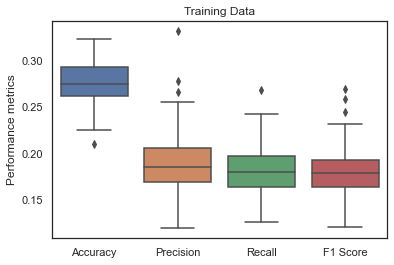

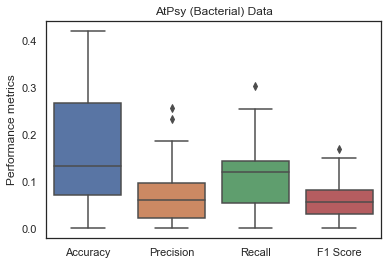

In [8]:
df_dnn_scores = pd.DataFrame(dnn_scores)
df_AtPsy_dnn_scores = pd.DataFrame(AtPsy_dnn_scores)

sns.boxplot(data=df_dnn_scores)
plt.title('Training Data')
plt.ylabel('Performance metrics')
plt.show()

sns.boxplot(data=df_AtPsy_dnn_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

saving figure at ../results/03_At/figures/03a11c_dnn_random1000.png


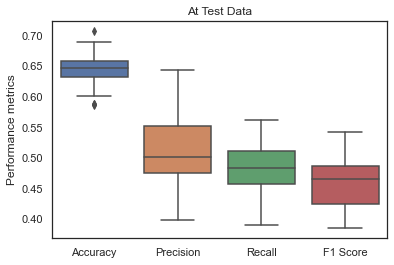

In [65]:
df_dnn_adj_scores = pd.DataFrame(dnn_adj_scores)
df_AtPsy_dnn_adj_scores = pd.DataFrame(AtPsy_dnn_adj_scores)

sns.boxplot(data=df_dnn_adj_scores)
plt.title('At Test Data')
plt.ylabel('Performance metrics')

filename = f'../results/03_At/figures/{nb_id}_dnn_random{topN}.png'
print(f'saving figure at {filename}')
plt.savefig(filename, dpi=600)
plt.show()


In [50]:
np.shape(df_dnn_adj_scores)

(100, 4)

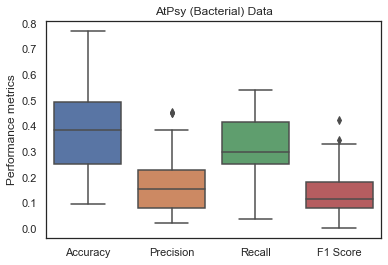

In [10]:
sns.boxplot(data=df_AtPsy_dnn_adj_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

## XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

### Train

In [11]:
# Run multiple iterations

xgb_y_preds = [0] * rand_iters
xgb_scores = [0] * rand_iters
xgb_cms = [0] * rand_iters
xgb_adj_scores = [0] * rand_iters

AtPsy_xgb_scores = [0] * rand_iters
AtPsy_xgb_cms = [0] * rand_iters
AtPsy_xgb_adj_scores = [0] * rand_iters

for i in range(rand_iters):
    X_train = df_X_train_samples[i].to_numpy()
    X_test = df_X_test_samples[i].to_numpy()
    At_X_test_scaled = df_At_X_test_scaled_samples[i].to_numpy()
    AtPsy_X_test_scaled = df_AtPsy_X_test_scaled_samples[i].to_numpy()

    xgb = XGBClassifier()

    t0 = time.time()
    xgb.fit(X_train, y_train)
    t = time.time() - t0
        
    # Evaluate performance on Test set1
    xgb_y_pred = xgb.predict(X_test)
    
    xgb_y_preds[i] = xgb_y_pred
    xgb_scores[i] = get_sk_metrics(y_test, xgb_y_pred, average='macro')
    xgb_cms[i] = metrics.confusion_matrix(y_test, xgb_y_pred)
    xgb_adj_scores[i] = get_fuzzy_average_score(xgb_cms[i])
    
    # Evaluate performance on Test set3 (AtPsy)
    X_test_scaled = AtPsy_X_test_scaled

    xgb_AtPsy_y_pred = xgb.predict(X_test_scaled)
    AtPsy_xgb_scores[i] = get_sk_metrics(y_test_AtPsy, xgb_AtPsy_y_pred)
    AtPsy_xgb_cms[i] = metrics.confusion_matrix(y_test_AtPsy, xgb_AtPsy_y_pred)
    AtPsy_xgb_adj_scores[i] = get_fuzzy_average_score(AtPsy_xgb_cms[i])

/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:34:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.44%
Precision:	 15.89%
Recall:		 16.30%
F1 score:	 15.64%
Accuracy:	 40.96%
Precision:	 6.41%
Recall:		 11.59%
F1 score:	 8.02%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:34:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.40%
Precision:	 22.49%
Recall:		 22.47%
F1 score:	 22.15%
Accuracy:	 31.33%
Precision:	 7.28%
Recall:		 11.07%
F1 score:	 8.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:34:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 32.32%
Precision:	 21.74%
Recall:		 21.37%
F1 score:	 21.29%
Accuracy:	 20.48%
Precision:	 6.08%
Recall:		 8.75%
F1 score:	 7.01%
[08:35:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.57%
Precision:	 19.08%
Recall:		 18.89%
F1 score:	 18.65%
Accuracy:	 31.33%
Precision:	 6.38%
Recall:		 10.18%
F1 score:	 7.83%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:35:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 23.01%
Recall:		 22.08%
F1 score:	 22.22%
Accuracy:	 33.73%
Precision:	 5.97%
Recall:		 11.43%
F1 score:	 7.84%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:35:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.22%
Precision:	 14.72%
Recall:		 15.56%
F1 score:	 14.93%
Accuracy:	 36.14%
Precision:	 5.00%
Recall:		 10.71%
F1 score:	 6.82%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:35:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 15.70%
Recall:		 17.04%
F1 score:	 15.93%
Accuracy:	 33.73%
Precision:	 6.66%
Recall:		 11.27%
F1 score:	 8.33%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:36:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 28.66%
Precision:	 22.69%
Recall:		 20.07%
F1 score:	 20.50%
Accuracy:	 38.55%
Precision:	 5.13%
Recall:		 11.43%
F1 score:	 7.08%
[08:36:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.83%
Precision:	 18.51%
Recall:		 16.86%
F1 score:	 17.26%
Accuracy:	 26.51%
Precision:	 7.45%
Recall:		 14.35%
F1 score:	 9.33%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:36:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.71%
Precision:	 18.58%
Recall:		 19.48%
F1 score:	 18.53%
Accuracy:	 34.94%
Precision:	 5.94%
Recall:		 10.36%
F1 score:	 7.55%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:36:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 21.60%
Recall:		 19.37%
F1 score:	 19.43%
Accuracy:	 27.71%
Precision:	 6.04%
Recall:		 12.02%
F1 score:	 7.43%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:37:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 19.07%
Recall:		 18.74%
F1 score:	 18.64%
Accuracy:	 34.94%
Precision:	 5.11%
Recall:		 10.36%
F1 score:	 6.84%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:37:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 26.52%
Precision:	 15.77%
Recall:		 15.70%
F1 score:	 15.55%
Accuracy:	 40.96%
Precision:	 5.59%
Recall:		 12.14%
F1 score:	 7.66%
[08:37:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.71%
Precision:	 22.49%
Recall:		 21.48%
F1 score:	 21.71%
Accuracy:	 36.14%
Precision:	 7.45%
Recall:		 10.32%
F1 score:	 7.78%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:37:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.83%
Precision:	 17.36%
Recall:		 17.53%
F1 score:	 17.18%
Accuracy:	 9.64%
Precision:	 10.97%
Recall:		 8.45%
F1 score:	 6.23%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:38:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 29.27%
Precision:	 19.99%
Recall:		 19.63%
F1 score:	 19.52%
Accuracy:	 20.48%
Precision:	 7.78%
Recall:		 6.76%
F1 score:	 6.69%
[08:38:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 19.78%
Recall:		 21.06%
F1 score:	 19.66%
Accuracy:	 34.94%
Precision:	 7.06%
Recall:		 10.79%
F1 score:	 8.41%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:38:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 34.15%
Precision:	 24.92%
Recall:		 24.15%
F1 score:	 24.08%
Accuracy:	 9.64%
Precision:	 6.77%
Recall:		 10.48%
F1 score:	 4.17%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:38:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.13%
Precision:	 20.82%
Recall:		 18.01%
F1 score:	 18.90%
Accuracy:	 16.87%
Precision:	 7.13%
Recall:		 9.42%
F1 score:	 6.59%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:39:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.27%
Precision:	 19.37%
Recall:		 19.79%
F1 score:	 19.35%
Accuracy:	 16.87%
Precision:	 6.83%
Recall:		 9.70%
F1 score:	 6.51%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:39:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 31.40%
Precision:	 20.22%
Recall:		 19.41%
F1 score:	 19.29%
Accuracy:	 39.76%
Precision:	 5.43%
Recall:		 11.79%
F1 score:	 7.43%
[08:39:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 29.27%
Precision:	 21.59%
Recall:		 19.48%
F1 score:	 19.45%
Accuracy:	 19.28%
Precision:	 8.44%
Recall:		 13.33%
F1 score:	 7.05%
[08:39:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 29.57%
Precision:	 19.60%
Recall:		 18.74%
F1 score:	 18.90%
Accuracy:	 19.28%
Precision:	 7.14%
Recall:		 5.71%
F1 score:	 6.35%
[08:39:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 25.34%
Recall:		 23.16%
F1 score:	 23.64%
Accuracy:	 7.23%
Precision:	 9.44%
Recall:		 3.31%
F1 score:	 4.57%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:40:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 32.32%
Precision:	 19.56%
Recall:		 20.18%
F1 score:	 19.19%
Accuracy:	 16.87%
Precision:	 9.77%
Recall:		 6.79%
F1 score:	 7.84%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:40:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.35%
Precision:	 16.78%
Recall:		 17.12%
F1 score:	 16.74%
Accuracy:	 27.71%
Precision:	 4.12%
Recall:		 7.30%
F1 score:	 5.27%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:40:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 32.01%
Precision:	 20.80%
Recall:		 20.73%
F1 score:	 20.25%
Accuracy:	 31.33%
Precision:	 7.30%
Recall:		 9.05%
F1 score:	 8.01%
[08:40:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.13%
Precision:	 16.66%
Recall:		 17.07%
F1 score:	 16.63%
Accuracy:	 39.76%
Precision:	 5.57%
Recall:		 11.79%
F1 score:	 7.57%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:41:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.66%
Precision:	 17.77%
Recall:		 18.31%
F1 score:	 17.92%
Accuracy:	 40.96%
Precision:	 6.00%
Recall:		 13.88%
F1 score:	 8.37%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:41:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.18%
Precision:	 18.61%
Recall:		 19.05%
F1 score:	 18.37%
Accuracy:	 31.33%
Precision:	 7.96%
Recall:		 11.96%
F1 score:	 9.51%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:41:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.57%
Precision:	 17.45%
Recall:		 17.88%
F1 score:	 17.43%
Accuracy:	 15.66%
Precision:	 5.88%
Recall:		 9.11%
F1 score:	 5.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:41:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.27%
Precision:	 17.24%
Recall:		 17.00%
F1 score:	 16.79%
Accuracy:	 39.76%
Precision:	 6.04%
Recall:		 13.47%
F1 score:	 8.34%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:42:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 25.00%
Precision:	 14.12%
Recall:		 14.29%
F1 score:	 13.96%
Accuracy:	 32.53%
Precision:	 8.54%
Recall:		 13.45%
F1 score:	 10.41%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:42:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.10%
Precision:	 17.57%
Recall:		 18.00%
F1 score:	 17.39%
Accuracy:	 13.25%
Precision:	 4.21%
Recall:		 3.49%
F1 score:	 3.82%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:42:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.40%
Precision:	 16.73%
Recall:		 17.95%
F1 score:	 17.06%
Accuracy:	 20.48%
Precision:	 6.64%
Recall:		 6.07%
F1 score:	 6.34%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:42:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.13%
Precision:	 17.83%
Recall:		 17.92%
F1 score:	 17.71%
Accuracy:	 33.73%
Precision:	 6.03%
Recall:		 10.00%
F1 score:	 7.53%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:43:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.27%
Precision:	 21.26%
Recall:		 19.26%
F1 score:	 19.20%
Accuracy:	 25.30%
Precision:	 6.53%
Recall:		 9.29%
F1 score:	 7.58%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.35%
Precision:	 20.25%
Recall:		 18.09%
F1 score:	 18.44%
Accuracy:	 21.69%
Precision:	 5.13%
Recall:		 7.30%
F1 score:	 5.85%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.88%
Precision:	 18.74%
Recall:		 18.48%
F1 score:	 18.33%
Accuracy:	 26.51%
Precision:	 7.67%
Recall:		 14.35%
F1 score:	 9.35%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:43:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.44%
Precision:	 16.83%
Recall:		 17.32%
F1 score:	 16.85%
Accuracy:	 38.55%
Precision:	 9.97%
Recall:		 18.44%
F1 score:	 12.20%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:44:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.35%
Precision:	 16.60%
Recall:		 17.30%
F1 score:	 16.71%
Accuracy:	 8.43%
Precision:	 8.66%
Recall:		 7.96%
F1 score:	 3.97%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:44:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.22%
Precision:	 16.49%
Recall:		 17.47%
F1 score:	 16.54%
Accuracy:	 24.10%
Precision:	 8.07%
Recall:		 11.61%
F1 score:	 8.41%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:44:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.52%
Precision:	 15.99%
Recall:		 16.56%
F1 score:	 16.07%
Accuracy:	 37.35%
Precision:	 4.72%
Recall:		 9.84%
F1 score:	 6.38%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:44:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.88%
Precision:	 18.72%
Recall:		 17.75%
F1 score:	 17.75%
Accuracy:	 21.69%
Precision:	 5.67%
Recall:		 9.68%
F1 score:	 6.54%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:45:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 25.30%
Precision:	 18.70%
Recall:		 16.97%
F1 score:	 17.23%
Accuracy:	 27.71%
Precision:	 6.08%
Recall:		 9.39%
F1 score:	 7.38%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 32.01%
Precision:	 21.54%
Recall:		 20.87%
F1 score:	 20.71%
Accuracy:	 14.46%
Precision:	 3.51%
Recall:		 3.81%
F1 score:	 3.65%
[08:45:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 28.96%
Precision:	 17.10%
Recall:		 17.03%
F1 score:	 16.70%
Accuracy:	 22.89%
Precision:	 20.94%
Recall:		 13.34%
F1 score:	 8.90%
[08:45:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.79%
Precision:	 20.40%
Recall:		 19.13%
F1 score:	 19.09%
Accuracy:	 31.33%
Precision:	 5.16%
Recall:		 9.29%
F1 score:	 6.63%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:46:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 32.32%
Precision:	 20.42%
Recall:		 19.84%
F1 score:	 19.67%
Accuracy:	 13.25%
Precision:	 6.22%
Recall:		 6.88%
F1 score:	 4.79%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:46:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.79%
Precision:	 17.59%
Recall:		 18.97%
F1 score:	 17.95%
Accuracy:	 34.94%
Precision:	 9.31%
Recall:		 16.61%
F1 score:	 11.14%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:46:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.57%
Precision:	 19.09%
Recall:		 17.93%
F1 score:	 18.14%
Accuracy:	 22.89%
Precision:	 6.29%
Recall:		 8.57%
F1 score:	 6.91%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:46:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.40%
Precision:	 19.25%
Recall:		 19.21%
F1 score:	 19.00%
Accuracy:	 14.46%
Precision:	 10.71%
Recall:		 4.29%
F1 score:	 6.12%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:47:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.83%
Precision:	 16.23%
Recall:		 16.39%
F1 score:	 16.04%
Accuracy:	 33.73%
Precision:	 6.37%
Recall:		 9.68%
F1 score:	 7.65%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:47:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.71%
Precision:	 18.59%
Recall:		 19.01%
F1 score:	 18.40%
Accuracy:	 26.51%
Precision:	 8.33%
Recall:		 9.42%
F1 score:	 8.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:47:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.88%
Precision:	 22.24%
Recall:		 21.46%
F1 score:	 21.60%
Accuracy:	 42.17%
Precision:	 6.02%
Recall:		 14.29%
F1 score:	 8.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:47:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 33.54%
Precision:	 21.48%
Recall:		 19.99%
F1 score:	 20.11%
Accuracy:	 30.12%
Precision:	 9.89%
Recall:		 15.42%
F1 score:	 11.60%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:47:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.83%
Precision:	 17.46%
Recall:		 16.82%
F1 score:	 16.85%
Accuracy:	 26.51%
Precision:	 8.95%
Recall:		 10.12%
F1 score:	 9.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:48:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.83%
Precision:	 14.52%
Recall:		 15.38%
F1 score:	 14.61%
Accuracy:	 16.87%
Precision:	 5.30%
Recall:		 5.00%
F1 score:	 5.15%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:48:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 27.74%
Precision:	 23.20%
Recall:		 18.01%
F1 score:	 18.77%
Accuracy:	 25.30%
Precision:	 9.58%
Recall:		 13.99%
F1 score:	 11.35%
[08:48:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.71%
Precision:	 21.98%
Recall:		 20.93%
F1 score:	 21.11%
Accuracy:	 37.35%
Precision:	 11.14%
Recall:		 15.77%
F1 score:	 11.30%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:48:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 33.84%
Precision:	 20.59%
Recall:		 20.63%
F1 score:	 20.23%
Accuracy:	 32.53%
Precision:	 4.82%
Recall:		 9.64%
F1 score:	 6.43%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:49:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 30.49%
Precision:	 19.73%
Recall:		 18.09%
F1 score:	 17.90%
Accuracy:	 24.10%
Precision:	 6.41%
Recall:		 14.76%
F1 score:	 7.43%
[08:49:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 31.40%
Precision:	 18.75%
Recall:		 19.00%
F1 score:	 18.46%
Accuracy:	 27.71%
Precision:	 5.11%
Recall:		 7.30%
F1 score:	 6.01%
[08:49:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.52%
Precision:	 17.48%
Recall:		 18.93%
F1 score:	 17.30%
Accuracy:	 21.69%
Precision:	 8.06%
Recall:		 11.79%
F1 score:	 8.85%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:49:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.44%
Precision:	 16.52%
Recall:		 16.44%
F1 score:	 16.16%
Accuracy:	 25.30%
Precision:	 6.52%
Recall:		 8.57%
F1 score:	 7.41%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.96%
Precision:	 20.07%
Recall:		 20.21%
F1 score:	 19.88%
Accuracy:	 24.10%
Precision:	 8.54%
Recall:		 10.95%
F1 score:	 8.06%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:50:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.27%
Precision:	 16.85%
Recall:		 16.55%
F1 score:	 16.32%
Accuracy:	 40.96%
Precision:	 5.59%
Recall:		 12.14%
F1 score:	 7.66%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:50:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 24.70%
Precision:	 17.10%
Recall:		 16.91%
F1 score:	 16.78%
Accuracy:	 36.14%
Precision:	 6.30%
Recall:		 12.91%
F1 score:	 8.16%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:50:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 33.23%
Precision:	 19.26%
Recall:		 19.84%
F1 score:	 19.15%
Accuracy:	 21.69%
Precision:	 6.03%
Recall:		 9.11%
F1 score:	 7.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:51:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.74%
Precision:	 18.55%
Recall:		 18.98%
F1 score:	 18.40%
Accuracy:	 21.69%
Precision:	 6.65%
Recall:		 9.11%
F1 score:	 7.28%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:51:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.05%
Precision:	 19.07%
Recall:		 18.17%
F1 score:	 18.24%
Accuracy:	 31.33%
Precision:	 12.53%
Recall:		 10.12%
F1 score:	 10.29%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:51:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 32.01%
Precision:	 19.85%
Recall:		 20.03%
F1 score:	 19.74%
Accuracy:	 31.33%
Precision:	 5.51%
Recall:		 9.29%
F1 score:	 6.91%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:51:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.27%
Precision:	 19.63%
Recall:		 18.74%
F1 score:	 18.89%
Accuracy:	 38.55%
Precision:	 5.63%
Recall:		 11.43%
F1 score:	 7.55%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:52:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.96%
Precision:	 20.42%
Recall:		 19.92%
F1 score:	 19.80%
Accuracy:	 6.02%
Precision:	 12.71%
Recall:		 5.60%
F1 score:	 2.97%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:52:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 25.00%
Precision:	 17.06%
Recall:		 16.97%
F1 score:	 16.86%
Accuracy:	 18.07%
Precision:	 4.08%
Recall:		 5.36%
F1 score:	 4.63%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:52:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.79%
Precision:	 16.36%
Recall:		 17.38%
F1 score:	 16.52%
Accuracy:	 34.94%
Precision:	 9.39%
Recall:		 13.17%
F1 score:	 10.44%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:52:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.44%
Precision:	 15.61%
Recall:		 16.55%
F1 score:	 15.77%
Accuracy:	 40.96%
Precision:	 5.04%
Recall:		 10.79%
F1 score:	 6.87%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:53:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.96%
Precision:	 17.61%
Recall:		 18.17%
F1 score:	 17.62%
Accuracy:	 28.92%
Precision:	 6.52%
Recall:		 8.57%
F1 score:	 7.41%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:53:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.22%
Precision:	 16.27%
Recall:		 16.14%
F1 score:	 15.94%
Accuracy:	 14.46%
Precision:	 6.08%
Recall:		 9.64%
F1 score:	 5.61%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:53:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 33.84%
Precision:	 23.46%
Recall:		 21.79%
F1 score:	 21.89%
Accuracy:	 19.28%
Precision:	 7.77%
Recall:		 6.61%
F1 score:	 7.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:54:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.18%
Precision:	 18.44%
Recall:		 19.24%
F1 score:	 18.61%
Accuracy:	 8.43%
Precision:	 8.52%
Recall:		 7.65%
F1 score:	 4.36%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:54:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.57%
Precision:	 19.16%
Recall:		 20.50%
F1 score:	 19.57%
Accuracy:	 16.87%
Precision:	 6.99%
Recall:		 10.60%
F1 score:	 6.86%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:54:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 25.30%
Precision:	 15.03%
Recall:		 15.13%
F1 score:	 14.74%
Accuracy:	 9.64%
Precision:	 3.29%
Recall:		 2.54%
F1 score:	 2.87%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:54:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 22.34%
Recall:		 20.41%
F1 score:	 20.85%
Accuracy:	 12.05%
Precision:	 3.12%
Recall:		 3.57%
F1 score:	 3.33%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:55:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 27.44%
Precision:	 16.38%
Recall:		 16.37%
F1 score:	 15.94%
Accuracy:	 40.96%
Precision:	 5.74%
Recall:		 12.14%
F1 score:	 7.80%
[08:55:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.13%
Precision:	 18.78%
Recall:		 18.16%
F1 score:	 18.00%
Accuracy:	 24.10%
Precision:	 5.14%
Recall:		 8.04%
F1 score:	 6.24%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:55:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.27%
Precision:	 18.41%
Recall:		 18.11%
F1 score:	 17.84%
Accuracy:	 12.05%
Precision:	 10.36%
Recall:		 8.15%
F1 score:	 6.79%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:55:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.05%
Precision:	 16.36%
Recall:		 16.64%
F1 score:	 16.20%
Accuracy:	 18.07%
Precision:	 6.46%
Recall:		 6.35%
F1 score:	 6.14%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:56:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 27.74%
Precision:	 18.06%
Recall:		 18.11%
F1 score:	 17.90%
Accuracy:	 18.07%
Precision:	 5.40%
Recall:		 12.98%
F1 score:	 5.87%
[08:56:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 32.01%
Precision:	 21.52%
Recall:		 22.00%
F1 score:	 21.54%
Accuracy:	 26.51%
Precision:	 17.97%
Recall:		 9.18%
F1 score:	 8.84%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:56:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 31.10%
Precision:	 19.64%
Recall:		 20.13%
F1 score:	 19.62%
Accuracy:	 16.87%
Precision:	 12.91%
Recall:		 13.25%
F1 score:	 8.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:56:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.49%
Precision:	 19.83%
Recall:		 19.33%
F1 score:	 19.15%
Accuracy:	 12.05%
Precision:	 3.83%
Recall:		 3.17%
F1 score:	 3.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/p

[08:57:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 33.54%
Precision:	 22.92%
Recall:		 21.04%
F1 score:	 20.81%
Accuracy:	 13.25%
Precision:	 11.35%
Recall:		 8.47%
F1 score:	 6.35%
[08:57:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 28.96%
Precision:	 20.22%
Recall:		 20.69%
F1 score:	 20.19%
Accuracy:	 31.33%
Precision:	 7.49%
Recall:		 13.99%
F1 score:	 9.35%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:57:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/mini

Accuracy:	 28.05%
Precision:	 16.27%
Recall:		 16.31%
F1 score:	 16.08%
Accuracy:	 38.55%
Precision:	 6.18%
Recall:		 13.06%
F1 score:	 8.39%
[08:57:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 32.32%
Precision:	 20.32%
Recall:		 20.88%
F1 score:	 20.17%
Accuracy:	 32.53%
Precision:	 10.08%
Recall:		 10.54%
F1 score:	 9.15%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:58:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 30.18%
Precision:	 17.47%
Recall:		 16.85%
F1 score:	 16.66%
Accuracy:	 9.64%
Precision:	 7.49%
Recall:		 14.29%
F1 score:	 3.88%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:58:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 29.57%
Precision:	 21.99%
Recall:		 19.81%
F1 score:	 20.44%
Accuracy:	 28.92%
Precision:	 7.63%
Recall:		 12.38%
F1 score:	 8.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:58:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 27.74%
Precision:	 21.22%
Recall:		 20.30%
F1 score:	 20.29%
Accuracy:	 36.14%
Precision:	 5.28%
Recall:		 10.71%
F1 score:	 7.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

[08:58:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:	 26.83%
Precision:	 15.41%
Recall:		 15.56%
F1 score:	 15.28%
Accuracy:	 33.73%
Precision:	 4.06%
Recall:		 8.00%
F1 score:	 5.38%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


In [35]:
# # Plots
# k = 5
# matrix = xgb_cms[k]

# df_cm = pd.DataFrame(matrix, columns=np.unique(y_test), index=np.unique(y_test))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize=(10, 7))
# sns.set(font_scale=1.4)
# sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font size

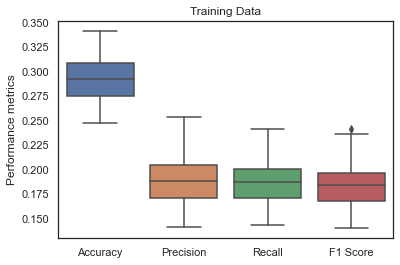

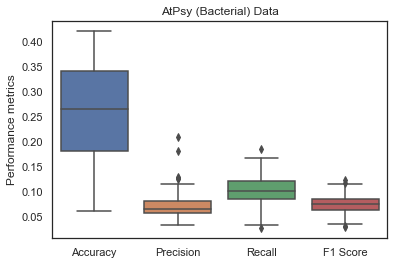

In [36]:
df_xgb_scores = pd.DataFrame(xgb_scores)
df_AtPsy_xgb_scores = pd.DataFrame(AtPsy_xgb_scores)

sns.boxplot(data=df_xgb_scores)
plt.title('Training Data')
plt.ylabel('Performance metrics')
plt.show()

sns.boxplot(data=df_AtPsy_xgb_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

saving figure at ../results/03_At/figures/03a11c_xgb_random1000.png


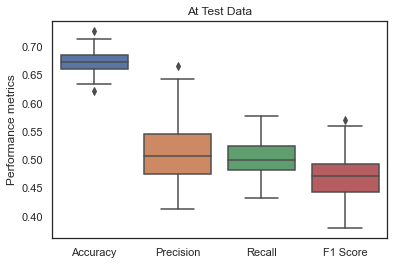

In [66]:
df_xgb_adj_scores = pd.DataFrame(xgb_adj_scores)
df_AtPsy_xgb_adj_scores = pd.DataFrame(AtPsy_xgb_adj_scores)

sns.boxplot(data=df_xgb_adj_scores)
plt.title('At Test Data')
plt.ylabel('Performance metrics')

filename = f'../results/03_At/figures/{nb_id}_xgb_random{topN}.png'
print(f'saving figure at {filename}')
plt.savefig(filename, dpi=600)

plt.show()

In [39]:
np.shape(df_xgb_adj_scores)

(100, 4)

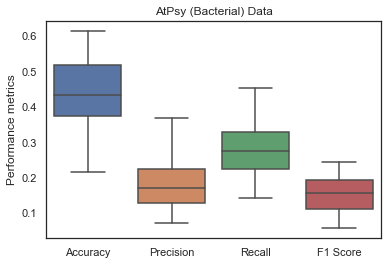

In [38]:
sns.boxplot(data=df_AtPsy_xgb_adj_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

## Random Forest

In [40]:
# Run multiple iterations
rf_y_preds = [0] * rand_iters
rf_scores = [0] * rand_iters
rf_cms = [0] * rand_iters
rf_adj_scores = [0] * rand_iters

AtPsy_rf_scores = [0] * rand_iters
AtPsy_rf_cms = [0] * rand_iters
AtPsy_rf_adj_scores = [0] * rand_iters

for i in range(rand_iters):
    X_train = df_X_train_samples[i].to_numpy()
    X_test = df_X_test_samples[i].to_numpy()
    At_X_test_scaled = df_At_X_test_scaled_samples[i].to_numpy()
    AtPsy_X_test_scaled = df_AtPsy_X_test_scaled_samples[i].to_numpy()

    rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0)

    t0 = time.time()
    rf.fit(X_train, y_train)
    t = time.time() - t0
        
    # Evaluate performance on Test set1
    rf_y_pred = rf.predict(X_test)
    
    rf_y_preds[i] = rf_y_pred
    rf_scores[i] = get_sk_metrics(y_test, rf_y_pred, average='macro')
    rf_cms[i] = metrics.confusion_matrix(y_test, rf_y_pred)
    rf_adj_scores[i] = get_fuzzy_average_score(rf_cms[i])
    
    # Evaluate performance on Test set3 (AtPsy)
    X_test_scaled = AtPsy_X_test_scaled
    rf_AtPsy_y_pred = rf.predict(X_test_scaled)
    AtPsy_rf_scores[i] = get_sk_metrics(y_test_AtPsy, rf_AtPsy_y_pred)
    AtPsy_rf_cms[i] = metrics.confusion_matrix(y_test_AtPsy, rf_AtPsy_y_pred)
    AtPsy_rf_adj_scores[i] = get_fuzzy_average_score(AtPsy_rf_cms[i])

Accuracy:	 29.27%
Precision:	 17.75%
Recall:		 18.98%
F1 score:	 17.80%
Accuracy:	 9.64%
Precision:	 8.36%
Recall:		 11.13%
F1 score:	 7.94%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 19.00%
Recall:		 18.51%
F1 score:	 18.05%
Accuracy:	 13.25%
Precision:	 4.81%
Recall:		 6.61%
F1 score:	 4.93%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.18%
Precision:	 19.45%
Recall:		 19.55%
F1 score:	 18.96%
Accuracy:	 16.87%
Precision:	 7.68%
Recall:		 13.13%
F1 score:	 9.06%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/mini

Accuracy:	 28.96%
Precision:	 16.97%
Recall:		 17.84%
F1 score:	 16.96%
Accuracy:	 8.43%
Precision:	 4.26%
Recall:		 7.86%
F1 score:	 2.61%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 33.23%
Precision:	 26.41%
Recall:		 25.21%
F1 score:	 24.93%
Accuracy:	 26.51%
Precision:	 6.42%
Recall:		 9.64%
F1 score:	 7.68%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 30.49%
Precision:	 19.12%
Recall:		 19.99%
F1 score:	 18.96%
Accuracy:	 27.71%
Precision:	 4.87%
Recall:		 8.21%
F1 score:	 6.12%
Accuracy:	 29.57%
Precision:	 17.39%
Recall:		 18.01%
F1 score:	 17.24%
Accuracy:	 26.51%
Precision:	 4.82%
Recall:		 7.86%
F1 score:	 5.98%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 18.25%
Recall:		 19.18%
F1 score:	 18.12%
Accuracy:	 28.92%
Precision:	 7.20%
Recall:		 9.46%
F1 score:	 8.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.62%
Precision:	 22.41%
Recall:		 21.20%
F1 score:	 21.09%
Accuracy:	 18.07%
Precision:	 6.82%
Recall:		 10.06%
F1 score:	 6.97%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.93%
Precision:	 27.04%
Recall:		 21.70%
F1 score:	 22.25%
Accuracy:	 14.46%
Precision:	 5.62%
Recall:		 5.18%
F1 score:	 5.37%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 19.72%
Recall:		 21.43%
F1 score:	 19.59%
Accuracy:	 10.84%
Precision:	 5.11%
Recall:		 10.60%
F1 score:	 4.98%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.01%
Precision:	 20.96%
Recall:		 21.12%
F1 score:	 20.57%
Accuracy:	 25.30%
Precision:	 4.69%
Recall:		 7.50%
F1 score:	 5.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 30.49%
Precision:	 19.32%
Recall:		 21.27%
F1 score:	 19.87%
Accuracy:	 13.25%
Precision:	 5.72%
Recall:		 5.71%
F1 score:	 5.13%
Accuracy:	 31.40%
Precision:	 20.09%
Recall:		 20.41%
F1 score:	 19.74%
Accuracy:	 34.94%
Precision:	 5.49%
Recall:		 10.36%
F1 score:	 7.18%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.93%
Precision:	 24.51%
Recall:		 24.88%
F1 score:	 24.09%
Accuracy:	 22.89%
Precision:	 6.70%
Recall:		 8.57%
F1 score:	 7.52%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.18%
Precision:	 19.51%
Recall:		 20.23%
F1 score:	 19.24%
Accuracy:	 13.25%
Precision:	 3.22%
Recall:		 3.49%
F1 score:	 3.35%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 17.83%
Recall:		 18.77%
F1 score:	 17.89%
Accuracy:	 30.12%
Precision:	 8.25%
Recall:		 9.52%
F1 score:	 8.84%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 28.66%
Precision:	 19.03%
Recall:		 19.94%
F1 score:	 19.02%
Accuracy:	 18.07%
Precision:	 5.42%
Recall:		 12.98%
F1 score:	 6.07%
Accuracy:	 29.57%
Precision:	 20.57%
Recall:		 19.08%
F1 score:	 18.82%
Accuracy:	 22.89%
Precision:	 6.77%
Recall:		 10.60%
F1 score:	 7.26%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 31.10%
Precision:	 19.86%
Recall:		 21.09%
F1 score:	 20.00%
Accuracy:	 27.71%
Precision:	 6.33%
Recall:		 12.02%
F1 score:	 7.99%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 26.52%
Precision:	 15.84%
Recall:		 16.90%
F1 score:	 15.93%
Accuracy:	 19.28%
Precision:	 4.76%
Recall:		 5.71%
F1 score:	 5.19%
Accuracy:	 31.10%
Precision:	 19.65%
Recall:		 19.78%
F1 score:	 19.26%
Accuracy:	 10.84%
Precision:	 8.10%
Recall:		 9.90%
F1 score:	 5.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 17.79%
Recall:		 18.49%
F1 score:	 17.64%
Accuracy:	 28.92%
Precision:	 7.68%
Recall:		 9.46%
F1 score:	 8.40%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.88%
Precision:	 18.71%
Recall:		 19.33%
F1 score:	 18.42%
Accuracy:	 10.84%
Precision:	 4.86%
Recall:		 8.57%
F1 score:	 4.69%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.05%
Precision:	 16.92%
Recall:		 18.11%
F1 score:	 17.01%
Accuracy:	 14.46%
Precision:	 4.19%
Recall:		 5.18%
F1 score:	 4.63%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.18%
Precision:	 18.48%
Recall:		 18.46%
F1 score:	 17.89%
Accuracy:	 27.71%
Precision:	 9.10%
Recall:		 14.46%
F1 score:	 9.96%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.32%
Precision:	 21.92%
Recall:		 21.99%
F1 score:	 21.21%
Accuracy:	 10.84%
Precision:	 5.20%
Recall:		 7.68%
F1 score:	 4.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.96%
Precision:	 18.54%
Recall:		 19.26%
F1 score:	 18.59%
Accuracy:	 6.02%
Precision:	 2.23%
Recall:		 1.79%
F1 score:	 1.98%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 31.10%
Precision:	 18.95%
Recall:		 19.50%
F1 score:	 18.83%
Accuracy:	 22.89%
Precision:	 6.55%
Recall:		 12.14%
F1 score:	 7.46%
Accuracy:	 29.88%
Precision:	 18.64%
Recall:		 19.36%
F1 score:	 18.36%
Accuracy:	 6.02%
Precision:	 5.06%
Recall:		 4.46%
F1 score:	 2.66%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.88%
Precision:	 18.53%
Recall:		 19.22%
F1 score:	 18.10%
Accuracy:	 30.12%
Precision:	 8.26%
Recall:		 10.71%
F1 score:	 9.10%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.66%
Precision:	 17.50%
Recall:		 18.45%
F1 score:	 17.34%
Accuracy:	 26.51%
Precision:	 10.90%
Recall:		 16.13%
F1 score:	 12.67%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 32.62%
Precision:	 20.83%
Recall:		 21.82%
F1 score:	 20.71%
Accuracy:	 21.69%
Precision:	 8.12%
Recall:		 9.11%
F1 score:	 7.83%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 17.37%
Recall:		 17.89%
F1 score:	 17.16%
Accuracy:	 9.64%
Precision:	 5.75%
Recall:		 5.31%
F1 score:	 4.91%
Accuracy:	 28.05%
Precision:	 17.21%
Recall:		 18.56%
F1 score:	 17.26%
Accuracy:	 15.66%
Precision:	 9.64%
Recall:		 6.43%
F1 score:	 6.86%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.01%
Precision:	 19.29%
Recall:		 19.91%
F1 score:	 19.03%
Accuracy:	 33.73%
Precision:	 8.67%
Recall:		 10.89%
F1 score:	 9.51%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 31.71%
Precision:	 20.39%
Recall:		 21.25%
F1 score:	 20.48%
Accuracy:	 33.73%
Precision:	 8.10%
Recall:		 11.79%
F1 score:	 9.49%
Accuracy:	 28.96%
Precision:	 17.33%
Recall:		 17.92%
F1 score:	 17.16%
Accuracy:	 15.66%
Precision:	 8.71%
Recall:		 12.68%
F1 score:	 5.12%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 31.71%
Precision:	 19.63%
Recall:		 20.16%
F1 score:	 19.37%
Accuracy:	 36.14%
Precision:	 9.44%
Recall:		 14.29%
F1 score:	 11.35%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 29.57%
Precision:	 18.67%
Recall:		 19.69%
F1 score:	 18.85%
Accuracy:	 19.28%
Precision:	 8.55%
Recall:		 11.07%
F1 score:	 7.75%
Accuracy:	 27.44%
Precision:	 16.45%
Recall:		 17.75%
F1 score:	 16.53%
Accuracy:	 6.02%
Precision:	 4.17%
Recall:		 1.79%
F1 score:	 2.50%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.22%
Precision:	 15.26%
Recall:		 16.67%
F1 score:	 15.43%
Accuracy:	 9.64%
Precision:	 4.12%
Recall:		 4.64%
F1 score:	 3.87%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 33.54%
Precision:	 20.63%
Recall:		 20.83%
F1 score:	 20.31%
Accuracy:	 26.51%
Precision:	 4.74%
Recall:		 7.86%
F1 score:	 5.91%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.13%
Precision:	 16.95%
Recall:		 17.51%
F1 score:	 16.53%
Accuracy:	 33.73%
Precision:	 5.56%
Recall:		 10.00%
F1 score:	 7.14%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.01%
Precision:	 19.96%
Recall:		 21.67%
F1 score:	 20.12%
Accuracy:	 18.07%
Precision:	 4.62%
Recall:		 7.14%
F1 score:	 5.53%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 34.15%
Precision:	 25.67%
Recall:		 22.02%
F1 score:	 21.70%
Accuracy:	 39.76%
Precision:	 5.09%
Recall:		 11.79%
F1 score:	 7.11%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 19.84%
Recall:		 20.04%
F1 score:	 19.51%
Accuracy:	 42.17%
Precision:	 8.24%
Recall:		 13.39%
F1 score:	 9.74%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 19.03%
Recall:		 19.36%
F1 score:	 18.69%
Accuracy:	 32.53%
Precision:	 6.03%
Recall:		 9.64%
F1 score:	 7.42%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.57%
Precision:	 17.64%
Recall:		 19.05%
F1 score:	 17.69%
Accuracy:	 10.84%
Precision:	 4.57%
Recall:		 5.00%
F1 score:	 4.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.05%
Precision:	 17.39%
Recall:		 19.27%
F1 score:	 17.70%
Accuracy:	 33.73%
Precision:	 6.96%
Recall:		 10.89%
F1 score:	 8.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 32.01%
Precision:	 22.38%
Recall:		 22.16%
F1 score:	 21.46%
Accuracy:	 16.87%
Precision:	 5.80%
Recall:		 10.36%
F1 score:	 6.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 28.05%
Precision:	 17.78%
Recall:		 17.43%
F1 score:	 16.94%
Accuracy:	 14.46%
Precision:	 4.55%
Recall:		 4.29%
F1 score:	 4.41%
Accuracy:	 29.88%
Precision:	 19.70%
Recall:		 19.60%
F1 score:	 18.81%
Accuracy:	 24.10%
Precision:	 8.29%
Recall:		 11.61%
F1 score:	 9.19%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.96%
Precision:	 21.85%
Recall:		 21.35%
F1 score:	 21.11%
Accuracy:	 37.35%
Precision:	 5.78%
Recall:		 11.07%
F1 score:	 7.60%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.44%
Precision:	 22.46%
Recall:		 19.33%
F1 score:	 18.98%
Accuracy:	 18.07%
Precision:	 6.73%
Recall:		 7.14%
F1 score:	 6.92%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 31.40%
Precision:	 19.72%
Recall:		 19.41%
F1 score:	 19.14%
Accuracy:	 21.69%
Precision:	 5.33%
Recall:		 7.32%
F1 score:	 6.09%
Accuracy:	 31.10%
Precision:	 19.56%
Recall:		 19.76%
F1 score:	 19.14%
Accuracy:	 24.10%
Precision:	 8.10%
Recall:		 10.53%
F1 score:	 9.05%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 28.66%
Precision:	 17.90%
Recall:		 18.41%
F1 score:	 17.61%
Accuracy:	 19.28%
Precision:	 4.44%
Recall:		 5.71%
F1 score:	 5.00%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 28.05%
Precision:	 22.00%
Recall:		 19.34%
F1 score:	 18.97%
Accuracy:	 27.71%
Precision:	 7.87%
Recall:		 8.52%
F1 score:	 7.00%
Accuracy:	 28.66%
Precision:	 21.25%
Recall:		 19.65%
F1 score:	 19.63%
Accuracy:	 27.71%
Precision:	 6.71%
Recall:		 13.74%
F1 score:	 8.69%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 18.23%
Recall:		 19.14%
F1 score:	 18.27%
Accuracy:	 21.69%
Precision:	 6.43%
Recall:		 10.24%
F1 score:	 7.21%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 28.05%
Precision:	 18.55%
Recall:		 18.83%
F1 score:	 18.26%
Accuracy:	 22.89%
Precision:	 6.09%
Recall:		 7.68%
F1 score:	 6.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 30.49%
Precision:	 18.68%
Recall:		 19.75%
F1 score:	 18.53%
Accuracy:	 40.96%
Precision:	 9.90%
Recall:		 13.04%
F1 score:	 9.63%
Accuracy:	 29.88%
Precision:	 16.48%
Recall:		 18.05%
F1 score:	 16.74%
Accuracy:	 28.92%
Precision:	 5.00%
Recall:		 8.57%
F1 score:	 6.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 21.96%
Recall:		 23.21%
F1 score:	 21.74%
Accuracy:	 6.02%
Precision:	 4.46%
Recall:		 1.79%
F1 score:	 2.55%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 17.63%
Recall:		 19.44%
F1 score:	 17.92%
Accuracy:	 22.89%
Precision:	 6.01%
Recall:		 8.57%
F1 score:	 7.03%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.01%
Precision:	 20.35%
Recall:		 20.50%
F1 score:	 19.54%
Accuracy:	 18.07%
Precision:	 5.21%
Recall:		 9.17%
F1 score:	 5.72%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 31.10%
Precision:	 20.57%
Recall:		 22.18%
F1 score:	 20.75%
Accuracy:	 31.33%
Precision:	 5.42%
Recall:		 9.29%
F1 score:	 6.84%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.57%
Precision:	 19.40%
Recall:		 19.96%
F1 score:	 19.14%
Accuracy:	 21.69%
Precision:	 6.16%
Recall:		 7.32%
F1 score:	 6.60%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 30.18%
Precision:	 18.81%
Recall:		 20.06%
F1 score:	 18.83%
Accuracy:	 21.69%
Precision:	 6.86%
Recall:		 11.13%
F1 score:	 7.78%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 28.05%
Precision:	 17.86%
Recall:		 17.52%
F1 score:	 17.17%
Accuracy:	 19.28%
Precision:	 6.87%
Recall:		 10.42%
F1 score:	 8.23%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 29.88%
Precision:	 18.08%
Recall:		 18.59%
F1 score:	 17.94%
Accuracy:	 7.23%
Precision:	 3.69%
Recall:		 7.74%
F1 score:	 4.21%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 33.23%
Precision:	 19.57%
Recall:		 21.61%
F1 score:	 20.01%
Accuracy:	 24.10%
Precision:	 6.31%
Recall:		 10.95%
F1 score:	 7.86%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 26.22%
Precision:	 15.48%
Recall:		 16.76%
F1 score:	 15.70%
Accuracy:	 14.46%
Precision:	 19.32%
Recall:		 9.84%
F1 score:	 8.64%
Accuracy:	 30.18%
Precision:	 18.86%
Recall:		 19.81%
F1 score:	 18.90%
Accuracy:	 10.84%
Precision:	 5.85%
Recall:		 5.89%
F1 score:	 4.97%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 31.71%
Precision:	 20.02%
Recall:		 21.96%
F1 score:	 20.46%
Accuracy:	 21.69%
Precision:	 7.76%
Recall:		 9.11%
F1 score:	 7.78%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 31.71%
Precision:	 20.19%
Recall:		 20.64%
F1 score:	 19.95%
Accuracy:	 12.05%
Precision:	 3.05%
Recall:		 3.57%
F1 score:	 3.29%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 27.13%
Precision:	 15.93%
Recall:		 17.84%
F1 score:	 16.31%
Accuracy:	 18.07%
Precision:	 5.58%
Recall:		 8.04%
F1 score:	 6.21%
Accuracy:	 26.83%
Precision:	 16.18%
Recall:		 17.38%
F1 score:	 16.31%
Accuracy:	 6.02%
Precision:	 2.83%
Recall:		 3.57%
F1 score:	 2.29%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.32%
Precision:	 25.11%
Recall:		 22.06%
F1 score:	 22.04%
Accuracy:	 33.73%
Precision:	 8.18%
Recall:		 14.46%
F1 score:	 10.22%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 29.88%
Precision:	 18.42%
Recall:		 18.62%
F1 score:	 18.13%
Accuracy:	 16.87%
Precision:	 4.93%
Recall:		 5.89%
F1 score:	 5.31%
Accuracy:	 32.93%
Precision:	 20.95%
Recall:		 20.95%
F1 score:	 20.38%
Accuracy:	 8.43%
Precision:	 4.00%
Recall:		 6.07%
F1 score:	 3.38%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.57%
Precision:	 17.19%
Recall:		 17.86%
F1 score:	 16.99%
Accuracy:	 19.28%
Precision:	 7.22%
Recall:		 13.33%
F1 score:	 7.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 31.10%
Precision:	 19.43%
Recall:		 21.13%
F1 score:	 19.72%
Accuracy:	 38.55%
Precision:	 5.71%
Recall:		 11.43%
F1 score:	 7.62%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 29.27%
Precision:	 18.47%
Recall:		 19.04%
F1 score:	 18.40%
Accuracy:	 18.07%
Precision:	 6.98%
Recall:		 7.14%
F1 score:	 6.92%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 31.40%
Precision:	 20.11%
Recall:		 20.85%
F1 score:	 20.02%
Accuracy:	 24.10%
Precision:	 7.33%
Recall:		 8.04%
F1 score:	 7.54%
Accuracy:	 30.79%
Precision:	 18.23%
Recall:		 19.20%
F1 score:	 18.11%
Accuracy:	 14.46%
Precision:	 5.35%
Recall:		 6.98%
F1 score:	 5.42%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 28.05%
Precision:	 15.36%
Recall:		 16.48%
F1 score:	 15.55%
Accuracy:	 14.46%
Precision:	 5.61%
Recall:		 6.07%
F1 score:	 5.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 28.96%
Precision:	 18.62%
Recall:		 18.54%
F1 score:	 18.10%
Accuracy:	 26.51%
Precision:	 6.47%
Recall:		 8.75%
F1 score:	 7.36%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

Accuracy:	 27.13%
Precision:	 16.14%
Recall:		 16.42%
F1 score:	 15.57%
Accuracy:	 19.28%
Precision:	 5.27%
Recall:		 6.61%
F1 score:	 5.74%
Accuracy:	 28.35%
Precision:	 21.23%
Recall:		 21.03%
F1 score:	 20.82%
Accuracy:	 16.87%
Precision:	 7.54%
Recall:		 5.89%
F1 score:	 6.55%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.96%
Precision:	 22.68%
Recall:		 20.97%
F1 score:	 20.66%
Accuracy:	 9.64%
Precision:	 8.33%
Recall:		 6.67%
F1 score:	 5.39%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 32.32%
Precision:	 19.97%
Recall:		 21.74%
F1 score:	 20.06%
Accuracy:	 12.05%
Precision:	 6.58%
Recall:		 3.57%
F1 score:	 4.63%
Accuracy:	 31.40%
Precision:	 19.95%
Recall:		 19.95%
F1 score:	 19.52%
Accuracy:	 36.14%
Precision:	 7.83%
Recall:		 18.33%
F1 score:	 10.71%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 18.29%
Recall:		 18.94%
F1 score:	 18.14%
Accuracy:	 8.43%
Precision:	 3.98%
Recall:		 6.96%
F1 score:	 3.15%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 32.93%
Precision:	 23.65%
Recall:		 22.48%
F1 score:	 21.91%
Accuracy:	 36.14%
Precision:	 7.56%
Recall:		 13.27%
F1 score:	 9.58%
Accuracy:	 30.79%
Precision:	 18.62%
Recall:		 19.67%
F1 score:	 18.51%
Accuracy:	 4.82%
Precision:	 9.92%
Recall:		 6.13%
F1 score:	 3.49%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.05%
Precision:	 17.32%
Recall:		 17.76%
F1 score:	 17.02%
Accuracy:	 16.87%
Precision:	 6.26%
Recall:		 9.70%
F1 score:	 6.32%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 19.52%
Recall:		 19.58%
F1 score:	 19.15%
Accuracy:	 25.30%
Precision:	 6.56%
Recall:		 10.18%
F1 score:	 7.59%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 31.40%
Precision:	 20.86%
Recall:		 21.77%
F1 score:	 20.78%
Accuracy:	 21.69%
Precision:	 6.39%
Recall:		 8.21%
F1 score:	 7.12%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with n

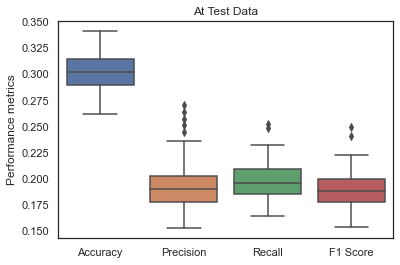

saving figure at ../results/03_At/figures/03a11b_rf_random1000.png


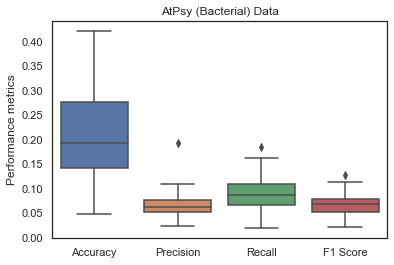

In [57]:
df_rf_scores = pd.DataFrame(rf_scores)
df_AtPsy_rf_scores = pd.DataFrame(AtPsy_rf_scores)

sns.boxplot(data=df_rf_scores)
plt.title('At Test Data')
plt.ylabel('Performance metrics')
plt.show()

sns.boxplot(data=df_AtPsy_rf_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')

plt.show()


saving figure at ../results/03_At/figures/03a11c_rf_random1000.png


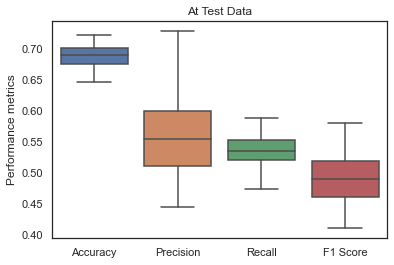

In [67]:
df_rf_adj_scores = pd.DataFrame(rf_adj_scores)
df_AtPsy_rf_adj_scores = pd.DataFrame(AtPsy_rf_adj_scores)

sns.boxplot(data=df_rf_adj_scores)
plt.title('At Test Data')
plt.ylabel('Performance metrics')

filename = f'../results/03_At/figures/{nb_id}_rf_random{topN}.png'
print(f'saving figure at {filename}')
plt.savefig(filename, dpi=600)

plt.show()

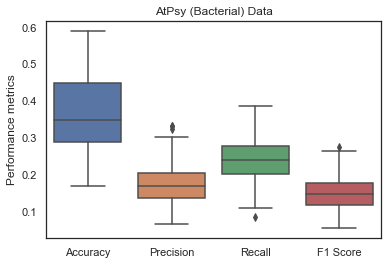

In [43]:
sns.boxplot(data=df_AtPsy_rf_adj_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

## SVM

In [44]:
# Run multiple iterations

svm_y_preds = [0] * rand_iters
svm_scores = [0] * rand_iters
svm_cms = [0] * rand_iters
svm_adj_scores = [0] * rand_iters

AtPsy_svm_scores = [0] * rand_iters
AtPsy_svm_cms = [0] * rand_iters
AtPsy_svm_adj_scores = [0] * rand_iters

for i in range(rand_iters):
    X_train = df_X_train_samples[i].to_numpy()
    X_test = df_X_test_samples[i].to_numpy()
    At_X_test_scaled = df_At_X_test_scaled_samples[i].to_numpy()
    AtPsy_X_test_scaled = df_AtPsy_X_test_scaled_samples[i].to_numpy()

    svm = SVC() 

    t0 = time.time()
    svm.fit(X_train, y_train)
    t = time.time() - t0
        
    # Evaluate performance on Test set1
    svm_y_pred = svm.predict(X_test)
    
    svm_y_preds[i] = svm_y_pred
    svm_scores[i] = get_sk_metrics(y_test, svm_y_pred, average='macro')
    svm_cms[i] = metrics.confusion_matrix(y_test, svm_y_pred)
    svm_adj_scores[i] = get_fuzzy_average_score(svm_cms[i])
    
#     # Evaluate performance on Test set2

    # Evaluate performance on Test set3 (AtPsy)
    X_test_scaled = AtPsy_X_test_scaled
    
    svm_AtPsy_y_pred = svm.predict(X_test_scaled)
    AtPsy_svm_scores[i] = get_sk_metrics(y_test_AtPsy, svm_AtPsy_y_pred)
    AtPsy_svm_cms[i] = metrics.confusion_matrix(y_test_AtPsy, svm_AtPsy_y_pred)
    AtPsy_svm_adj_scores[i] = get_fuzzy_average_score(AtPsy_svm_cms[i])

Accuracy:	 25.30%
Precision:	 16.76%
Recall:		 14.92%
F1 score:	 14.74%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/mini

Accuracy:	 27.44%
Precision:	 16.95%
Recall:		 16.27%
F1 score:	 16.07%
Accuracy:	 13.25%
Precision:	 16.03%
Recall:		 14.69%
F1 score:	 3.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.83%
Precision:	 22.48%
Recall:		 17.52%
F1 score:	 18.08%
Accuracy:	 13.25%
Precision:	 16.07%
Recall:		 14.69%
F1 score:	 3.97%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.74%
Precision:	 17.06%
Recall:		 16.71%
F1 score:	 16.47%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 20.40%
Recall:		 18.43%
F1 score:	 18.51%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.96%
Precision:	 18.98%
Recall:		 17.41%
F1 score:	 17.44%
Accuracy:	 3.61%
Precision:	 0.60%
Recall:		 14.29%
F1 score:	 1.14%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.71%
Precision:	 18.40%
Recall:		 18.42%
F1 score:	 17.90%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 18.19%
Recall:		 17.46%
F1 score:	 17.26%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.79%
Precision:	 20.09%
Recall:		 19.19%
F1 score:	 19.03%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.57%
Precision:	 18.19%
Recall:		 18.30%
F1 score:	 17.85%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.71%
Precision:	 20.03%
Recall:		 18.78%
F1 score:	 18.59%
Accuracy:	 12.05%
Precision:	 1.74%
Recall:		 14.29%
F1 score:	 3.11%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 32.32%
Precision:	 19.06%
Recall:		 18.71%
F1 score:	 18.14%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 19.49%
Recall:		 17.77%
F1 score:	 17.91%
Accuracy:	 13.25%
Precision:	 6.55%
Recall:		 14.69%
F1 score:	 3.93%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 16.84%
Recall:		 16.22%
F1 score:	 15.85%
Accuracy:	 22.89%
Precision:	 13.72%
Recall:		 15.92%
F1 score:	 9.40%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 17.23%
Recall:		 16.58%
F1 score:	 16.04%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 22.45%
Recall:		 17.27%
F1 score:	 17.30%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.44%
Precision:	 18.10%
Recall:		 16.63%
F1 score:	 16.56%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.10%
Precision:	 19.96%
Recall:		 18.63%
F1 score:	 18.49%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 17.11%
Recall:		 16.74%
F1 score:	 16.41%
Accuracy:	 16.87%
Precision:	 10.48%
Recall:		 12.86%
F1 score:	 6.79%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.74%
Precision:	 21.54%
Recall:		 17.77%
F1 score:	 18.26%
Accuracy:	 21.69%
Precision:	 16.19%
Recall:		 17.55%
F1 score:	 8.68%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.22%
Precision:	 17.64%
Recall:		 16.24%
F1 score:	 16.38%
Accuracy:	 16.87%
Precision:	 16.09%
Recall:		 15.92%
F1 score:	 6.14%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.57%
Precision:	 19.53%
Recall:		 18.20%
F1 score:	 18.14%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.57%
Precision:	 18.70%
Recall:		 17.65%
F1 score:	 17.47%
Accuracy:	 20.48%
Precision:	 16.17%
Recall:		 17.14%
F1 score:	 8.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.57%
Precision:	 25.93%
Recall:		 19.50%
F1 score:	 20.39%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.18%
Precision:	 18.06%
Recall:		 17.92%
F1 score:	 17.28%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.83%
Precision:	 17.26%
Recall:		 16.98%
F1 score:	 16.62%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 17.36%
Recall:		 16.47%
F1 score:	 16.10%
Accuracy:	 20.48%
Precision:	 16.17%
Recall:		 17.14%
F1 score:	 8.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 19.30%
Recall:		 18.80%
F1 score:	 18.46%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.44%
Precision:	 19.98%
Recall:		 16.83%
F1 score:	 17.05%
Accuracy:	 12.05%
Precision:	 1.74%
Recall:		 14.29%
F1 score:	 3.11%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 17.74%
Recall:		 17.06%
F1 score:	 16.72%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 18.87%
Recall:		 18.72%
F1 score:	 18.34%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.27%
Precision:	 20.08%
Recall:		 18.26%
F1 score:	 18.44%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.13%
Precision:	 19.07%
Recall:		 16.38%
F1 score:	 16.50%
Accuracy:	 12.05%
Precision:	 1.74%
Recall:		 14.29%
F1 score:	 3.11%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.96%
Precision:	 17.24%
Recall:		 16.81%
F1 score:	 16.45%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.40%
Precision:	 20.49%
Recall:		 18.99%
F1 score:	 18.88%
Accuracy:	 22.89%
Precision:	 16.22%
Recall:		 17.96%
F1 score:	 9.25%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.83%
Precision:	 17.44%
Recall:		 16.53%
F1 score:	 16.39%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.96%
Precision:	 28.33%
Recall:		 17.90%
F1 score:	 18.46%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 18.90%
Recall:		 18.28%
F1 score:	 18.01%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 17.94%
Recall:		 17.06%
F1 score:	 16.79%
Accuracy:	 24.10%
Precision:	 16.24%
Recall:		 18.37%
F1 score:	 9.79%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 16.66%
Recall:		 16.46%
F1 score:	 16.02%
Accuracy:	 16.87%
Precision:	 10.04%
Recall:		 15.92%
F1 score:	 6.04%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 17.78%
Recall:		 17.21%
F1 score:	 17.05%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.44%
Precision:	 22.33%
Recall:		 16.99%
F1 score:	 17.39%
Accuracy:	 13.25%
Precision:	 8.91%
Recall:		 14.69%
F1 score:	 3.91%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 18.56%
Recall:		 17.59%
F1 score:	 17.51%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.18%
Precision:	 18.72%
Recall:		 18.57%
F1 score:	 18.14%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 17.46%
Recall:		 16.85%
F1 score:	 16.69%
Accuracy:	 13.25%
Precision:	 16.03%
Recall:		 14.69%
F1 score:	 3.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.18%
Precision:	 22.06%
Recall:		 18.93%
F1 score:	 19.12%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.13%
Precision:	 16.99%
Recall:		 16.22%
F1 score:	 15.94%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.44%
Precision:	 17.42%
Recall:		 16.49%
F1 score:	 16.24%
Accuracy:	 15.66%
Precision:	 10.40%
Recall:		 15.51%
F1 score:	 5.39%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 17.74%
Recall:		 16.66%
F1 score:	 16.58%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 18.74%
Recall:		 17.98%
F1 score:	 17.79%
Accuracy:	 12.05%
Precision:	 1.74%
Recall:		 14.29%
F1 score:	 3.11%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 18.88%
Recall:		 17.13%
F1 score:	 17.06%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 18.59%
Recall:		 17.41%
F1 score:	 17.40%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 18.58%
Recall:		 17.30%
F1 score:	 17.43%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 19.11%
Recall:		 16.95%
F1 score:	 17.15%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.74%
Precision:	 23.16%
Recall:		 17.09%
F1 score:	 17.70%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 17.27%
Recall:		 17.02%
F1 score:	 16.58%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 17.74%
Recall:		 17.68%
F1 score:	 17.15%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.40%
Precision:	 23.51%
Recall:		 19.96%
F1 score:	 20.45%
Accuracy:	 3.61%
Precision:	 0.52%
Recall:		 14.29%
F1 score:	 1.00%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 17.52%
Recall:		 17.12%
F1 score:	 16.88%
Accuracy:	 8.43%
Precision:	 1.69%
Recall:		 10.00%
F1 score:	 2.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 19.48%
Recall:		 18.75%
F1 score:	 18.66%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.83%
Precision:	 17.52%
Recall:		 16.42%
F1 score:	 16.37%
Accuracy:	 13.25%
Precision:	 16.03%
Recall:		 14.69%
F1 score:	 3.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.79%
Precision:	 23.18%
Recall:		 18.84%
F1 score:	 19.02%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.18%
Precision:	 21.03%
Recall:		 18.19%
F1 score:	 18.31%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 17.35%
Recall:		 17.23%
F1 score:	 16.66%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.57%
Precision:	 22.94%
Recall:		 18.82%
F1 score:	 19.47%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.18%
Precision:	 21.45%
Recall:		 18.98%
F1 score:	 19.29%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 32.32%
Precision:	 25.28%
Recall:		 20.07%
F1 score:	 20.30%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.40%
Precision:	 31.15%
Recall:		 20.11%
F1 score:	 20.94%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 19.25%
Recall:		 18.72%
F1 score:	 18.49%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.74%
Precision:	 20.12%
Recall:		 17.83%
F1 score:	 18.04%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 18.62%
Recall:		 17.08%
F1 score:	 17.06%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 17.70%
Recall:		 17.39%
F1 score:	 16.92%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.57%
Precision:	 20.39%
Recall:		 18.17%
F1 score:	 18.28%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.74%
Precision:	 17.80%
Recall:		 16.74%
F1 score:	 16.69%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 17.74%
Recall:		 17.49%
F1 score:	 17.19%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.27%
Precision:	 17.88%
Recall:		 17.62%
F1 score:	 17.28%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 17.68%
Recall:		 16.83%
F1 score:	 16.63%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.83%
Precision:	 15.47%
Recall:		 15.26%
F1 score:	 14.81%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.18%
Precision:	 18.95%
Recall:		 18.43%
F1 score:	 17.86%
Accuracy:	 14.46%
Precision:	 16.05%
Recall:		 15.10%
F1 score:	 4.68%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 19.81%
Recall:		 17.94%
F1 score:	 18.01%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 19.63%
Recall:		 18.83%
F1 score:	 18.61%
Accuracy:	 13.25%
Precision:	 16.03%
Recall:		 14.69%
F1 score:	 3.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 32.01%
Precision:	 19.24%
Recall:		 18.52%
F1 score:	 18.11%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.13%
Precision:	 18.59%
Recall:		 17.38%
F1 score:	 17.51%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 19.11%
Recall:		 16.90%
F1 score:	 16.79%
Accuracy:	 13.25%
Precision:	 16.03%
Recall:		 14.69%
F1 score:	 3.90%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 25.61%
Precision:	 16.27%
Recall:		 15.09%
F1 score:	 14.83%
Accuracy:	 38.55%
Precision:	 14.59%
Recall:		 23.27%
F1 score:	 14.57%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 18.64%
Recall:		 16.76%
F1 score:	 16.79%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.44%
Precision:	 16.73%
Recall:		 16.51%
F1 score:	 16.12%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 32.62%
Precision:	 20.42%
Recall:		 19.93%
F1 score:	 19.67%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 19.00%
Recall:		 17.58%
F1 score:	 17.53%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.27%
Precision:	 17.69%
Recall:		 17.45%
F1 score:	 17.13%
Accuracy:	 19.28%
Precision:	 16.14%
Recall:		 16.73%
F1 score:	 7.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 18.76%
Recall:		 17.78%
F1 score:	 17.50%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.13%
Precision:	 17.01%
Recall:		 16.49%
F1 score:	 16.25%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 16.49%
Recall:		 17.17%
F1 score:	 16.33%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.10%
Precision:	 22.12%
Recall:		 18.57%
F1 score:	 18.74%
Accuracy:	 18.07%
Precision:	 16.12%
Recall:		 16.33%
F1 score:	 6.82%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.71%
Precision:	 21.43%
Recall:		 19.71%
F1 score:	 19.75%
Accuracy:	 18.07%
Precision:	 10.33%
Recall:		 15.31%
F1 score:	 6.91%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.27%
Precision:	 17.69%
Recall:		 17.27%
F1 score:	 16.81%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.05%
Precision:	 17.58%
Recall:		 17.00%
F1 score:	 16.74%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 19.89%
Recall:		 18.82%
F1 score:	 18.66%
Accuracy:	 12.05%
Precision:	 1.72%
Recall:		 14.29%
F1 score:	 3.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.10%
Precision:	 22.95%
Recall:		 19.02%
F1 score:	 19.42%
Accuracy:	 18.07%
Precision:	 16.12%
Recall:		 16.33%
F1 score:	 6.82%
Accuracy:	 26.83%
Precision:	 16.69%
Recall:		 16.36%
F1 score:	 16.00%
Accuracy:	 7.23%
Precision:	 1.11%
Recall:		 8.57%
F1 score:	 1.97%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


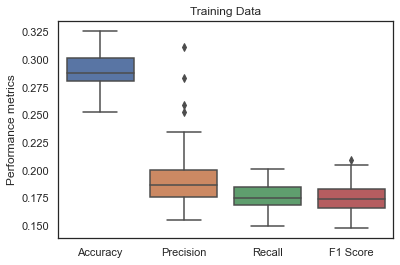

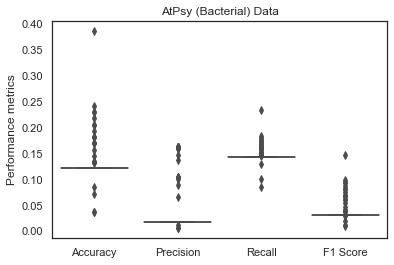

In [45]:
df_svm_scores = pd.DataFrame(svm_scores)
df_AtPsy_svm_scores = pd.DataFrame(AtPsy_svm_scores)

sns.boxplot(data=df_svm_scores)
plt.title('Training Data')
plt.ylabel('Performance metrics')
plt.show()

sns.boxplot(data=df_AtPsy_svm_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

saving figure at ../results/03_At/figures/03a11c_svm_random1000.png


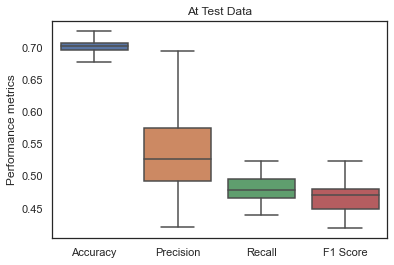

In [68]:
df_svm_adj_scores = pd.DataFrame(svm_adj_scores)
df_AtPsy_svm_adj_scores = pd.DataFrame(AtPsy_svm_adj_scores)

sns.boxplot(data=df_svm_adj_scores)
plt.title('At Test Data')
plt.ylabel('Performance metrics')

filename = f'../results/03_At/figures/{nb_id}_svm_random{topN}.png'
print(f'saving figure at {filename}')
plt.savefig(filename, dpi=600)

plt.show()

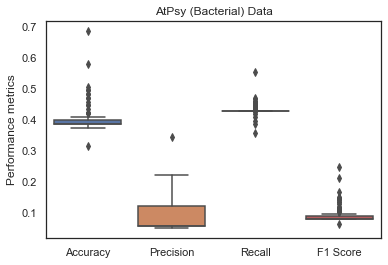

In [47]:
sns.boxplot(data=df_AtPsy_svm_adj_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

## SVM
### RBF kernel
#### Train

In [24]:
# # Run multiple iterations

# svm_y_preds = [0] * rand_iters
# svm_scores = [0] * rand_iters
# svm_cms = [0] * rand_iters

# AtPsy_svm_scores = [0] * rand_iters

# for i in range(rand_iters):
#     X_train = df_X_train_samples[i].to_numpy()
#     X_test = df_X_test_samples[i].to_numpy()
#     At_X_test_scaled = df_At_X_test_scaled_samples[i].to_numpy()
#     AtPsy_X_test_scaled = df_AtPsy_X_test_scaled_samples[i].to_numpy()

#     svm = SVC() 

#     t0 = time.time()
#     svm.fit(X_train, y_train)
#     t = time.time() - t0
        
#     # Evaluate performance on Test set1
#     svm_y_pred = svm.predict(X_test)
    
#     svm_y_preds[i] = svm_y_pred
#     svm_scores[i] = get_sk_metrics(y_test, svm_y_pred, average='macro')
#     svm_cms[i] = plot_confusion_matrix(y_test, svm_y_pred)
    
#     # Evaluate performance on Test set3 (AtPsy)
#     X_test_scaled = AtPsy_X_test_scaled

#     svm_AtPsy_y_pred = svm.predict(X_test_scaled)
#     AtPsy_svm_scores[i] = get_sk_metrics(y_test_AtPsy, svm_AtPsy_y_pred)

In [25]:
# # Plots
# k = 5
# matrix = svm_cms[k]

# df_cm = pd.DataFrame(matrix, columns=np.unique(y_test), index=np.unique(y_test))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize=(10, 7))
# sns.set(font_scale=1.4)
# sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font size

In [26]:
# df_svm_scores = pd.DataFrame(svm_scores)
# df_AtPsy_svm_scores = pd.DataFrame(AtPsy_svm_scores)

# sns.boxplot(data=df_svm_scores)
# plt.title('Training Data')
# plt.ylabel('Performance metrics')
# plt.show()

In [27]:
# sns.boxplot(data=df_AtPsy_svm_scores)
# plt.title('AtPsy (Bacterial) Data')
# plt.ylabel('Performance metrics')
# plt.show()

### Linear kernel
#### Train

In [60]:
# Run multiple iterations

svm_lin_y_preds = [0] * rand_iters
svm_lin_scores = [0] * rand_iters
svm_lin_cms = [0] * rand_iters
svm_lin_adj_scores = [0] * rand_iters

AtPsy_svm_lin_scores = [0] * rand_iters
AtPsy_svm_lin_cms = [0] * rand_iters
AtPsy_svm_lin_adj_scores = [0] * rand_iters

for i in range(rand_iters):
    X_train = df_X_train_samples[i].to_numpy()
    X_test = df_X_test_samples[i].to_numpy()
    At_X_test_scaled = df_At_X_test_scaled_samples[i].to_numpy()
    AtPsy_X_test_scaled = df_AtPsy_X_test_scaled_samples[i].to_numpy()

    svm_lin = SVC(kernel='linear') # Linear Kernel

    t0 = time.time()
    #Train the model using the training sets
    svm_lin.fit(X_train, y_train)
    t = time.time() - t0
        
    # Evaluate performance on Test set1
    svm_lin_y_pred = svm_lin.predict(X_test)
    
    svm_lin_y_preds[i] = svm_lin_y_pred
    svm_lin_scores[i] = get_sk_metrics(y_test, svm_lin_y_pred, average='macro')
    svm_lin_cms[i] = metrics.confusion_matrix(y_test, svm_lin_y_pred)
    svm_lin_adj_scores[i] = get_fuzzy_average_score(svm_lin_cms[i])
    
    # Evaluate performance on Test set3 (AtPsy)
    X_test_scaled = AtPsy_X_test_scaled
    svm_lin_AtPsy_y_pred = svm_lin.predict(X_test_scaled)
    AtPsy_svm_lin_scores[i] = get_sk_metrics(y_test_AtPsy, svm_lin_AtPsy_y_pred)
    AtPsy_svm_lin_cms[i] = metrics.confusion_matrix(y_test_AtPsy, svm_lin_AtPsy_y_pred)
    AtPsy_svm_lin_adj_scores[i] = get_fuzzy_average_score(AtPsy_svm_lin_cms[i])

Accuracy:	 22.87%
Precision:	 14.67%
Recall:		 14.02%
F1 score:	 13.95%
Accuracy:	 27.71%
Precision:	 5.53%
Recall:		 8.21%
F1 score:	 6.61%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.52%
Precision:	 17.13%
Recall:		 16.60%
F1 score:	 16.69%
Accuracy:	 36.14%
Precision:	 7.38%
Recall:		 13.49%
F1 score:	 9.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 19.78%
Recall:		 19.51%
F1 score:	 19.44%
Accuracy:	 15.66%
Precision:	 19.69%
Recall:		 21.22%
F1 score:	 12.21%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.44%
Precision:	 17.19%
Recall:		 17.19%
F1 score:	 16.98%
Accuracy:	 21.69%
Precision:	 8.57%
Recall:		 19.11%
F1 score:	 9.67%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.96%
Precision:	 19.52%
Recall:		 19.43%
F1 score:	 19.17%
Accuracy:	 20.48%
Precision:	 5.77%
Recall:		 14.29%
F1 score:	 7.19%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 26.22%
Precision:	 17.64%
Recall:		 16.91%
F1 score:	 16.92%
Accuracy:	 33.73%
Precision:	 12.26%
Recall:		 17.51%
F1 score:	 13.83%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.22%
Precision:	 16.24%
Recall:		 16.45%
F1 score:	 16.14%
Accuracy:	 3.61%
Precision:	 4.42%
Recall:		 6.96%
F1 score:	 1.70%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 30.79%
Precision:	 20.89%
Recall:		 20.42%
F1 score:	 20.35%
Accuracy:	 12.05%
Precision:	 1.87%
Recall:		 12.50%
F1 score:	 3.25%
Accuracy:	 30.49%
Precision:	 20.69%
Recall:		 19.69%
F1 score:	 19.57%
Accuracy:	 14.46%
Precision:	 3.85%
Recall:		 4.29%
F1 score:	 4.05%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.35%
Precision:	 18.69%
Recall:		 19.15%
F1 score:	 18.81%
Accuracy:	 21.69%
Precision:	 20.50%
Recall:		 13.28%
F1 score:	 10.20%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 19.35%
Recall:		 18.32%
F1 score:	 18.61%
Accuracy:	 36.14%
Precision:	 8.12%
Recall:		 12.50%
F1 score:	 9.80%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 25.61%
Precision:	 16.72%
Recall:		 16.07%
F1 score:	 16.12%
Accuracy:	 8.43%
Precision:	 3.81%
Recall:		 11.43%
F1 score:	 3.96%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 19.76%
Recall:		 18.52%
F1 score:	 18.90%
Accuracy:	 42.17%
Precision:	 6.02%
Recall:		 14.29%
F1 score:	 8.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 24.09%
Precision:	 16.21%
Recall:		 15.80%
F1 score:	 15.59%
Accuracy:	 24.10%
Precision:	 5.32%
Recall:		 7.14%
F1 score:	 6.10%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.40%
Precision:	 21.32%
Recall:		 19.18%
F1 score:	 19.48%
Accuracy:	 34.94%
Precision:	 6.21%
Recall:		 14.17%
F1 score:	 8.52%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 18.09%
Recall:		 17.59%
F1 score:	 17.55%
Accuracy:	 9.64%
Precision:	 3.20%
Recall:		 5.93%
F1 score:	 2.94%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.96%
Precision:	 20.92%
Recall:		 20.00%
F1 score:	 20.26%
Accuracy:	 37.35%
Precision:	 17.53%
Recall:		 22.86%
F1 score:	 19.28%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 32.32%
Precision:	 25.28%
Recall:		 24.17%
F1 score:	 24.42%
Accuracy:	 6.02%
Precision:	 14.85%
Recall:		 28.57%
F1 score:	 15.37%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 17.45%
Recall:		 17.32%
F1 score:	 17.14%
Accuracy:	 33.73%
Precision:	 4.86%
Recall:		 10.00%
F1 score:	 6.54%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 25.12%
Recall:		 23.63%
F1 score:	 23.96%
Accuracy:	 34.94%
Precision:	 7.18%
Recall:		 14.17%
F1 score:	 8.85%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 27.44%
Precision:	 18.86%
Recall:		 17.90%
F1 score:	 18.10%
Accuracy:	 28.92%
Precision:	 7.60%
Recall:		 18.89%
F1 score:	 9.53%
Accuracy:	 27.13%
Precision:	 20.85%
Recall:		 20.25%
F1 score:	 20.05%
Accuracy:	 0.00%
Precision:	 0.00%
Recall:		 0.00%
F1 score:	 0.00%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 25.61%
Precision:	 16.50%
Recall:		 16.61%
F1 score:	 16.46%
Accuracy:	 2.41%
Precision:	 2.22%
Recall:		 6.61%
F1 score:	 2.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.22%
Precision:	 16.63%
Recall:		 16.41%
F1 score:	 16.31%
Accuracy:	 4.82%
Precision:	 10.00%
Recall:		 1.14%
F1 score:	 2.05%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 31.40%
Precision:	 19.09%
Recall:		 18.91%
F1 score:	 18.69%
Accuracy:	 37.35%
Precision:	 22.62%
Recall:		 26.47%
F1 score:	 12.29%
Accuracy:	 24.09%
Precision:	 16.89%
Recall:		 15.93%
F1 score:	 16.21%
Accuracy:	 8.43%
Precision:	 5.52%
Recall:		 19.47%
F1 score:	 6.34%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.83%
Precision:	 17.81%
Recall:		 17.36%
F1 score:	 17.32%
Accuracy:	 19.28%
Precision:	 5.39%
Recall:		 5.08%
F1 score:	 5.23%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 19.94%
Recall:		 19.24%
F1 score:	 19.35%
Accuracy:	 16.87%
Precision:	 7.64%
Recall:		 25.31%
F1 score:	 9.22%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 20.22%
Recall:		 20.23%
F1 score:	 19.98%
Accuracy:	 6.02%
Precision:	 5.99%
Recall:		 11.75%
F1 score:	 1.98%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 31.10%
Precision:	 20.37%
Recall:		 19.58%
F1 score:	 19.65%
Accuracy:	 32.53%
Precision:	 34.48%
Recall:		 16.73%
F1 score:	 19.16%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.66%
Precision:	 19.21%
Recall:		 19.50%
F1 score:	 19.08%
Accuracy:	 12.05%
Precision:	 11.97%
Recall:		 13.65%
F1 score:	 5.72%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 18.28%
Recall:		 18.01%
F1 score:	 18.01%
Accuracy:	 28.92%
Precision:	 25.15%
Recall:		 22.11%
F1 score:	 19.20%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 19.68%
Recall:		 19.03%
F1 score:	 19.20%
Accuracy:	 34.94%
Precision:	 5.58%
Recall:		 10.36%
F1 score:	 7.25%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 18.94%
Recall:		 18.44%
F1 score:	 18.39%
Accuracy:	 10.84%
Precision:	 3.54%
Recall:		 5.24%
F1 score:	 3.78%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 19.47%
Recall:		 19.53%
F1 score:	 19.33%
Accuracy:	 42.17%
Precision:	 6.02%
Recall:		 14.29%
F1 score:	 8.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 21.95%
Precision:	 16.69%
Recall:		 14.39%
F1 score:	 14.95%
Accuracy:	 7.23%
Precision:	 3.91%
Recall:		 13.93%
F1 score:	 3.11%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 24.39%
Precision:	 16.99%
Recall:		 16.33%
F1 score:	 16.42%
Accuracy:	 13.25%
Precision:	 10.19%
Recall:		 3.49%
F1 score:	 5.20%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.57%
Precision:	 23.62%
Recall:		 21.77%
F1 score:	 22.29%
Accuracy:	 12.05%
Precision:	 4.04%
Recall:		 18.00%
F1 score:	 6.60%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.35%
Precision:	 17.56%
Recall:		 17.34%
F1 score:	 17.24%
Accuracy:	 33.73%
Precision:	 7.41%
Recall:		 8.89%
F1 score:	 8.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.13%
Precision:	 17.15%
Recall:		 16.81%
F1 score:	 16.69%
Accuracy:	 40.96%
Precision:	 5.38%
Recall:		 12.14%
F1 score:	 7.46%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 25.91%
Precision:	 16.64%
Recall:		 16.59%
F1 score:	 16.47%
Accuracy:	 38.55%
Precision:	 6.53%
Recall:		 13.06%
F1 score:	 8.71%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.40%
Precision:	 22.14%
Recall:		 21.01%
F1 score:	 20.96%
Accuracy:	 20.48%
Precision:	 15.95%
Recall:		 11.70%
F1 score:	 12.28%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.96%
Precision:	 22.34%
Recall:		 20.08%
F1 score:	 20.67%
Accuracy:	 7.23%
Precision:	 4.96%
Recall:		 17.50%
F1 score:	 7.73%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 16.77%
Recall:		 17.77%
F1 score:	 17.12%
Accuracy:	 6.02%
Precision:	 1.10%
Recall:		 6.25%
F1 score:	 1.87%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 19.58%
Recall:		 19.51%
F1 score:	 19.18%
Accuracy:	 7.23%
Precision:	 7.50%
Recall:		 2.14%
F1 score:	 3.33%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.96%
Precision:	 20.63%
Recall:		 19.21%
F1 score:	 19.57%
Accuracy:	 8.43%
Precision:	 11.99%
Recall:		 15.92%
F1 score:	 3.93%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 24.70%
Precision:	 16.30%
Recall:		 15.63%
F1 score:	 15.76%
Accuracy:	 13.25%
Precision:	 17.77%
Recall:		 14.00%
F1 score:	 14.22%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.44%
Precision:	 18.00%
Recall:		 18.51%
F1 score:	 18.10%
Accuracy:	 25.30%
Precision:	 5.07%
Recall:		 6.67%
F1 score:	 5.76%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 24.39%
Precision:	 16.25%
Recall:		 17.38%
F1 score:	 16.63%
Accuracy:	 6.02%
Precision:	 13.90%
Recall:		 13.65%
F1 score:	 12.57%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 34.45%
Precision:	 25.26%
Recall:		 23.83%
F1 score:	 24.22%
Accuracy:	 34.94%
Precision:	 6.37%
Recall:		 11.84%
F1 score:	 8.29%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.79%
Precision:	 19.02%
Recall:		 18.44%
F1 score:	 18.33%
Accuracy:	 15.66%
Precision:	 14.64%
Recall:		 26.94%
F1 score:	 9.01%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.13%
Precision:	 17.62%
Recall:		 16.97%
F1 score:	 17.07%
Accuracy:	 14.46%
Precision:	 4.73%
Recall:		 11.45%
F1 score:	 6.46%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.88%
Precision:	 18.68%
Recall:		 18.21%
F1 score:	 18.20%
Accuracy:	 12.05%
Precision:	 8.79%
Recall:		 13.34%
F1 score:	 6.63%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 31.40%
Precision:	 20.79%
Recall:		 19.72%
F1 score:	 19.92%
Accuracy:	 33.73%
Precision:	 14.61%
Recall:		 25.90%
F1 score:	 15.72%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.44%
Precision:	 18.12%
Recall:		 17.49%
F1 score:	 17.54%
Accuracy:	 7.23%
Precision:	 2.42%
Recall:		 2.14%
F1 score:	 2.27%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 18.91%
Recall:		 18.91%
F1 score:	 18.46%
Accuracy:	 24.10%
Precision:	 5.88%
Recall:		 5.71%
F1 score:	 5.80%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 28.96%
Precision:	 19.96%
Recall:		 19.74%
F1 score:	 19.63%
Accuracy:	 8.43%
Precision:	 4.38%
Recall:		 2.50%
F1 score:	 3.18%
Accuracy:	 28.05%
Precision:	 18.88%
Recall:		 18.41%
F1 score:	 18.41%
Accuracy:	 10.84%
Precision:	 1.52%
Recall:		 11.25%
F1 score:	 2.68%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 25.30%
Precision:	 21.60%
Recall:		 21.77%
F1 score:	 21.34%
Accuracy:	 40.96%
Precision:	 6.23%
Recall:		 13.88%
F1 score:	 8.60%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.96%
Precision:	 19.49%
Recall:		 18.99%
F1 score:	 18.97%
Accuracy:	 4.82%
Precision:	 11.59%
Recall:		 2.06%
F1 score:	 2.43%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 25.30%
Precision:	 16.86%
Recall:		 16.75%
F1 score:	 16.54%
Accuracy:	 20.48%
Precision:	 8.98%
Recall:		 11.96%
F1 score:	 9.38%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.13%
Precision:	 18.76%
Recall:		 18.05%
F1 score:	 18.17%
Accuracy:	 10.84%
Precision:	 7.50%
Recall:		 2.57%
F1 score:	 3.83%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 21.13%
Recall:		 18.98%
F1 score:	 19.48%
Accuracy:	 19.28%
Precision:	 7.54%
Recall:		 4.81%
F1 score:	 5.81%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.13%
Precision:	 16.86%
Recall:		 16.18%
F1 score:	 16.18%
Accuracy:	 18.07%
Precision:	 6.39%
Recall:		 15.24%
F1 score:	 6.81%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 25.91%
Precision:	 17.15%
Recall:		 17.05%
F1 score:	 16.85%
Accuracy:	 13.25%
Precision:	 6.11%
Recall:		 6.19%
F1 score:	 5.30%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 19.98%
Recall:		 19.01%
F1 score:	 19.20%
Accuracy:	 40.96%
Precision:	 5.38%
Recall:		 12.14%
F1 score:	 7.46%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.79%
Precision:	 18.47%
Recall:		 17.90%
F1 score:	 17.87%
Accuracy:	 20.48%
Precision:	 10.77%
Recall:		 25.00%
F1 score:	 11.55%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.83%
Precision:	 17.80%
Recall:		 17.39%
F1 score:	 17.17%
Accuracy:	 30.12%
Precision:	 17.09%
Recall:		 18.25%
F1 score:	 11.45%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.05%
Precision:	 19.92%
Recall:		 19.89%
F1 score:	 19.35%
Accuracy:	 9.64%
Precision:	 5.56%
Recall:		 2.54%
F1 score:	 3.49%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.18%
Precision:	 19.54%
Recall:		 18.76%
F1 score:	 18.83%
Accuracy:	 30.12%
Precision:	 5.90%
Recall:		 8.93%
F1 score:	 7.10%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 28.35%
Precision:	 18.45%
Recall:		 19.59%
F1 score:	 18.87%
Accuracy:	 38.55%
Precision:	 7.46%
Recall:		 20.63%
F1 score:	 10.13%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 29.27%
Precision:	 19.55%
Recall:		 19.16%
F1 score:	 19.08%
Accuracy:	 10.84%
Precision:	 1.59%
Recall:		 10.00%
F1 score:	 2.74%
Accuracy:	 26.83%
Precision:	 18.11%
Recall:		 17.75%
F1 score:	 17.73%
Accuracy:	 22.89%
Precision:	 3.96%
Recall:		 6.79%
F1 score:	 5.00%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 26.83%
Precision:	 18.58%
Recall:		 17.69%
F1 score:	 17.95%
Accuracy:	 12.05%
Precision:	 12.99%
Recall:		 4.08%
F1 score:	 6.21%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.74%
Precision:	 20.24%
Recall:		 19.36%
F1 score:	 19.64%
Accuracy:	 0.00%
Precision:	 0.00%
Recall:		 0.00%
F1 score:	 0.00%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 33.23%
Precision:	 21.88%
Recall:		 21.73%
F1 score:	 21.50%
Accuracy:	 12.05%
Precision:	 1.89%
Recall:		 12.50%
F1 score:	 3.29%
Accuracy:	 28.05%
Precision:	 24.50%
Recall:		 23.80%
F1 score:	 23.73%
Accuracy:	 14.46%
Precision:	 13.06%
Recall:		 22.22%
F1 score:	 14.43%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.27%
Precision:	 19.17%
Recall:		 18.10%
F1 score:	 18.36%
Accuracy:	 6.02%
Precision:	 12.38%
Recall:		 4.76%
F1 score:	 2.59%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 27.13%
Precision:	 19.85%
Recall:		 19.34%
F1 score:	 19.27%
Accuracy:	 44.58%
Precision:	 20.70%
Recall:		 28.57%
F1 score:	 23.14%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.79%
Precision:	 24.92%
Recall:		 23.44%
F1 score:	 23.79%
Accuracy:	 2.41%
Precision:	 1.08%
Recall:		 4.52%
F1 score:	 1.12%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.88%
Precision:	 21.34%
Recall:		 20.45%
F1 score:	 20.54%
Accuracy:	 39.76%
Precision:	 13.21%
Recall:		 26.94%
F1 score:	 17.72%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 31.10%
Precision:	 21.58%
Recall:		 20.87%
F1 score:	 20.91%
Accuracy:	 16.87%
Precision:	 5.19%
Recall:		 4.44%
F1 score:	 4.79%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 19.77%
Recall:		 19.48%
F1 score:	 19.38%
Accuracy:	 9.64%
Precision:	 7.41%
Recall:		 2.54%
F1 score:	 3.78%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 30.79%
Precision:	 21.91%
Recall:		 20.65%
F1 score:	 20.85%
Accuracy:	 14.46%
Precision:	 9.88%
Recall:		 13.99%
F1 score:	 9.60%
Accuracy:	 25.91%
Precision:	 17.54%
Recall:		 16.71%
F1 score:	 16.87%
Accuracy:	 30.12%
Precision:	 10.05%
Recall:		 24.52%
F1 score:	 13.24%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.35%
Precision:	 19.22%
Recall:		 18.31%
F1 score:	 18.41%
Accuracy:	 36.14%
Precision:	 7.62%
Recall:		 22.50%
F1 score:	 9.95%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.74%
Precision:	 16.41%
Recall:		 16.84%
F1 score:	 16.42%
Accuracy:	 27.71%
Precision:	 5.22%
Recall:		 7.30%
F1 score:	 6.08%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.96%
Precision:	 20.74%
Recall:		 19.81%
F1 score:	 20.07%
Accuracy:	 37.35%
Precision:	 4.97%
Recall:		 11.07%
F1 score:	 6.86%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 25.91%
Precision:	 18.00%
Recall:		 17.54%
F1 score:	 17.44%
Accuracy:	 10.84%
Precision:	 2.32%
Recall:		 11.33%
F1 score:	 3.77%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 27.13%
Precision:	 16.16%
Recall:		 16.25%
F1 score:	 15.97%
Accuracy:	 2.41%
Precision:	 11.11%
Recall:		 0.63%
F1 score:	 1.20%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])
/Users/jayson/miniconda3/envs/p

Accuracy:	 27.13%
Precision:	 19.52%
Recall:		 18.88%
F1 score:	 19.02%
Accuracy:	 21.69%
Precision:	 14.60%
Recall:		 20.02%
F1 score:	 14.97%
Accuracy:	 28.35%
Precision:	 19.82%
Recall:		 19.02%
F1 score:	 19.11%
Accuracy:	 12.05%
Precision:	 19.59%
Recall:		 23.81%
F1 score:	 14.78%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 29.57%
Precision:	 20.91%
Recall:		 20.22%
F1 score:	 20.01%
Accuracy:	 4.82%
Precision:	 14.81%
Recall:		 14.69%
F1 score:	 1.81%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 29.88%
Precision:	 23.58%
Recall:		 22.88%
F1 score:	 22.79%
Accuracy:	 28.92%
Precision:	 6.83%
Recall:		 9.46%
F1 score:	 7.93%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 23.78%
Precision:	 16.32%
Recall:		 15.25%
F1 score:	 15.59%
Accuracy:	 34.94%
Precision:	 11.69%
Recall:		 22.14%
F1 score:	 15.29%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 28.35%
Precision:	 21.45%
Recall:		 19.87%
F1 score:	 20.40%
Accuracy:	 8.43%
Precision:	 9.32%
Recall:		 11.56%
F1 score:	 4.07%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])


Accuracy:	 30.49%
Precision:	 19.66%
Recall:		 18.55%
F1 score:	 18.72%
Accuracy:	 4.82%
Precision:	 6.96%
Recall:		 9.05%
F1 score:	 2.60%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.49%
Precision:	 19.16%
Recall:		 19.01%
F1 score:	 18.68%
Accuracy:	 6.02%
Precision:	 13.97%
Recall:		 10.30%
F1 score:	 3.40%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.18%
Precision:	 23.59%
Recall:		 22.97%
F1 score:	 22.69%
Accuracy:	 33.73%
Precision:	 8.99%
Recall:		 17.43%
F1 score:	 11.42%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


Accuracy:	 30.18%
Precision:	 18.75%
Recall:		 18.68%
F1 score:	 18.43%
Accuracy:	 8.43%
Precision:	 2.78%
Recall:		 2.22%
F1 score:	 2.47%


/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jayson/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../atbotml/custom_fuctions.py:312: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_precision[i] = np.sum(cmT[i, min_idx:max_idx + 1]) / np.sum(cmT[i])
../atbotml/custom_fuctions.py:311: RuntimeWarning: invalid value encountered in long_scalars
  fuzzy_recall[i] = np.sum(cm[i, min_idx:max_idx + 1]) / np.sum(cm[i])


In [61]:
# # Plot
# k = 5
# matrix = svm_lin_cms[k]

# df_cm = pd.DataFrame(matrix, columns=np.unique(y_test), index=np.unique(y_test))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize=(10, 7))
# sns.set(font_scale=1.4)
# sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font size

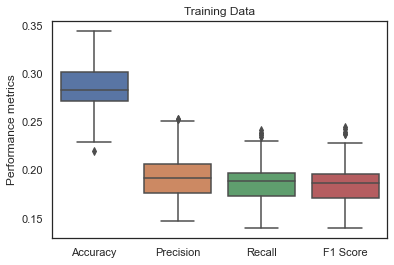

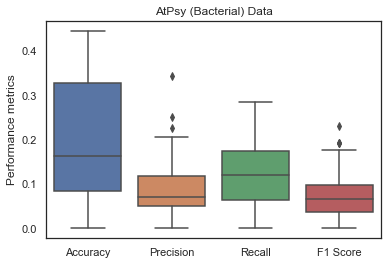

In [30]:
df_svm_lin_scores = pd.DataFrame(svm_lin_scores)
df_AtPsy_svm_lin_scores = pd.DataFrame(AtPsy_svm_lin_scores)

sns.boxplot(data=df_svm_lin_scores)
plt.title('Training Data')
plt.ylabel('Performance metrics')
plt.show()

sns.boxplot(data=df_AtPsy_svm_lin_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

saving figure at ../results/03_At/figures/03a11c_svm_lin_random1000.png


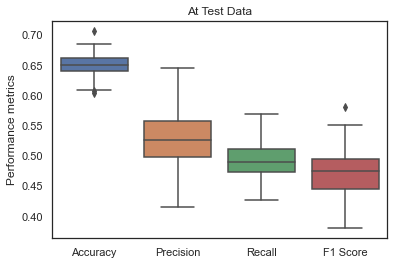

In [69]:
df_svm_lin_adj_scores = pd.DataFrame(svm_lin_adj_scores)
df_AtPsy_svm_lin_adj_scores = pd.DataFrame(AtPsy_svm_lin_adj_scores)

sns.boxplot(data=df_svm_lin_adj_scores)
plt.title('At Test Data')
plt.ylabel('Performance metrics')

filename = f'../results/03_At/figures/{nb_id}_svm_lin_random{topN}.png'
print(f'saving figure at {filename}')
plt.savefig(filename, dpi=600)

plt.show()

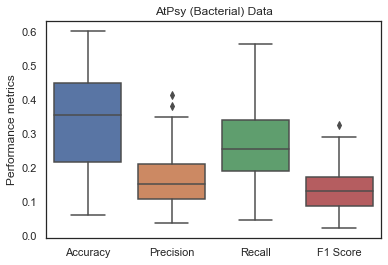

In [32]:
sns.boxplot(data=df_AtPsy_svm_lin_adj_scores)
plt.title('AtPsy (Bacterial) Data')
plt.ylabel('Performance metrics')
plt.show()

## Plots
### Performance metrics

**Precision** is a measure of the ability of a classification model to identify only the relevant data points.<br>
**Recall** is a measure of the ability of a model to find all the relevant cases within a dataset.

In [71]:
dnn_adj_acc = pd.DataFrame(dnn_adj_scores)['Accuracy']
xgb_adj_acc = pd.DataFrame(xgb_adj_scores)['Accuracy']
rf_adj_acc = pd.DataFrame(rf_adj_scores)['Accuracy']
svm_adj_acc = pd.DataFrame(svm_adj_scores)['Accuracy']
svm_lin_adj_acc = pd.DataFrame(svm_lin_adj_scores)['Accuracy']

saving figure at ../results/03_At/figures/03a11c_adj_acc_random1000.png


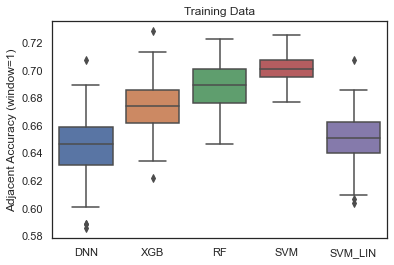

In [73]:
df_adj_acc_models = pd.DataFrame(data=[dnn_adj_acc, xgb_adj_acc, rf_adj_acc, svm_adj_acc, svm_lin_adj_acc])
df_adj_acc_models = df_adj_acc_models.T
df_adj_acc_models.columns = ['DNN', 'XGB', 'RF', 'SVM', 'SVM_LIN']

sns.boxplot(data=df_adj_acc_models)
plt.title('Training Data')
plt.ylabel('Adjacent Accuracy (window=1)')

filename = f'../results/03_At/figures/{nb_id}_adj_acc_random{topN}.png'
print(f'saving figure at {filename}')
plt.savefig(filename, dpi=600)

plt.show()

# df_adj_acc_models

In [74]:
df_adj_acc_models.describe()

,DNN,XGB,RF,SVM,SVM_LIN
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.643933,0.673476,0.687561,0.700884,0.650823
std,0.022300,0.018403,0.018208,0.009852,0.018351
min,0.585366,0.621951,0.646341,0.676829,0.603659
25%,0.631098,0.661585,0.676067,0.695122,0.640244
50%,0.646341,0.673780,0.689024,0.701220,0.650915
75%,0.658537,0.685976,0.701220,0.707317,0.662348
max,0.707317,0.728659,0.722561,0.725610,0.707317


In [ ]:
# OLD

In [ ]:
# max_ylim = 0.5
# file_out = f'./figures/{nb_long_id}_score_f{topN}.pdf'
# fig_title = 'At only features'
# df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, feature_size=topN)
# df_metrics

#### Fuzzy results

In [ ]:
# max_ylim = 0.8
# offset = 1
# file_out = f'./figures/{nb_long_id}_fuzzy_score_f{topN}.pdf'
# fig_title = f'At only features (class offset tolerance = {offset})'
# df_metrics = plot_performance_metrics(nb_long_id, max_ylim, file_out, fig_title, offset, feature_size=topN)
# df_metrics

### MSE

In [ ]:
# total_class_mse, class_mse, class_rss = class_error(dnn_cm)
# total_class_mse

# max_ylim = 3.5
# file_out = f'./figures/{nb_long_id}_mse_f{topN}.pdf'
# fig_title = f'At only features, class MSE'
# df_metrics = plot_mse(nb_long_id, max_ylim, file_out, fig_title, feature_size=topN)
# df_metrics

### Test2 prediction summary

In [ ]:
# cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
# ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
# df_test2_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

# print(f"{nb_long_id} Test Predictions")
# filename = f"../results/03_At/prediction/{nb_long_id}_test_predictions_f{topN}.pkl"
# pickle.dump(df_test2_predict, open(filename, 'wb'))
# print(f"Written to: {filename}")

# df_test2_predict

### Test3 prediction summary

In [ ]:
# cols = ['DNN', 'XGB', 'RF', 'SVM', 'linSVM']
# ml_predictions = np.vstack((dnn_y_pred, xgb_y_pred, rf_y_pred, svm_y_pred, svm_lin_y_pred)).T
# df_test3_predict = pd.DataFrame(data=ml_predictions, columns=cols, )

# print(f"{nb_long_id} Test Predictions")
# filename = f"../results/03_At/prediction/{nb_long_id}_test_AtPsy_predictions_f{topN}.pkl"
# pickle.dump(df_test3_predict, open(filename, 'wb'))
# print(f"Written to: {filename}")

# df_test3_predict